<a href="https://colab.research.google.com/github/cacress/CSC442/blob/main/notebooks/(Version_2)_Data_Cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INTRODUCTION**

Created by: **Colby Cress**

In this notebook, I perform exploratory data analysis around and create a query regarding the following question: **"How does the combination of genres listed for a show affect its popularity?"**

Because a show can have any number of genres (and many shows do have a large number of genres), the number of unique entries in the *genres* column is too large to feasibly do any analysis with them. As such, by taking the top two genres of a show (assumed to be most accurate by the order in which they are in) the genre data becomes narrower and much easier to analyze. This becomes clear upon visualizing the data.

In [17]:
import pandas as pd

# Import the modified data from initial data cleaning and wrangling
modified_df = pd.read_csv("https://raw.githubusercontent.com/cacress/CSC442/refs/heads/main/datasets/modified_v2.csv")

# modified_df.info()

# Starting analysis of first two genres vs. various metrics

The metrics for this analysis are as such:
1. Top two genres of a show
2. Number of seasons in a show
3. imdb_votes value of a show (number of votes)
4. tmdb_popularity value of a show (no direct translation, as the calculation formula for each show varies)
5. Average score (between imdb and tmdb) of a show
6. Age certification of a show
7. Release year of a show

## Setup variables

In [18]:
import ast

# The target column of interest in my EDA
target_column = "top_genres"
# Unique genres in the dataset
unique_genres = set()

for genres_str in modified_df['genres']:
    genres_list = ast.literal_eval(genres_str)
    unique_genres.update(genres_list)

unique_genres = list(unique_genres)
print(unique_genres)

['comedy', 'scifi', 'horror', 'family', 'animation', 'drama', 'war', 'reality', 'thriller', 'western', 'crime', 'history', 'european', 'romance', 'sport', 'documentation', 'action', 'music', 'fantasy']


## Create data query

### Data info before query

The dataset has the following aspects before the query:
* 7,688 entries
* 20 columns

In [19]:
print(modified_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7688 entries, 0 to 7687
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   title                            7688 non-null   object 
 1   type                             7688 non-null   object 
 2   release_year                     7688 non-null   int64  
 3   age_certification                4685 non-null   object 
 4   runtime                          7688 non-null   int64  
 5   genres                           7688 non-null   object 
 6   production_countries             7688 non-null   object 
 7   seasons                          3166 non-null   float64
 8   imdb_score                       7234 non-null   float64
 9   imdb_votes                       7219 non-null   float64
 10  tmdb_popularity                  7688 non-null   float64
 11  normalized_tmdb_score            7483 non-null   float64
 12  top_genres          

### Query

The query in my analysis removes any entries and features that were deemed to have little to no relationship to a show's genres. The following were removed:
* All entries that are not shows (aka movies)
* Features:
  * type, genres, production_countries, normalized_tmdb_score, genres_count, production_countries_count, score_difference, genres_uniqueness, production_countries_uniqueness, title_uniqueness_norm

Refer to the code comments for the reasoning for each feature being removed.

In [20]:
# Track the time this code block takes and print it out at the end
%%time

# Only keep rows that are shows - no movies
colby_df = modified_df[modified_df["type"] == "SHOW"].copy()

# Fill na seasons entries with 1 - assumed that if a show exists it should have at least one season
colby_df["seasons"] = colby_df["seasons"].fillna(1)

# Decided to keep the title column for easy visualization when looking at data

# Drop the type column because we now know that all rows left are shows
# Drop the genres column because we are now dealing only with top_genres
# Drop the production_countries column because it is vastly unrelated to the topic question
# Drop the normalized_tmdb_score, genres_count, production_countries_count, score_difference, genres_uniqueness, production_countries_uniqueness, and title_uniqueness_norm columns because they are leftover from Rithik's work
colby_df = colby_df.drop(columns = ["type", "genres", "production_countries", "normalized_tmdb_score", "genres_count", "production_countries_count", "score_difference", "genres_uniqueness", "production_countries_uniqueness", "title_uniqueness_norm"])

CPU times: user 6.07 ms, sys: 98 µs, total: 6.17 ms
Wall time: 5.88 ms


### Data info after query

The dataset has the following aspects after the query:
* 3,166 entries (4,522 entries dropped)
* 11 columns (9 columns dropped)

In [33]:
print(colby_df.info())
# display(colby_df)

<class 'pandas.core.frame.DataFrame'>
Index: 3166 entries, 0 to 7687
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              3166 non-null   object 
 1   release_year       3166 non-null   int64  
 2   age_certification  2787 non-null   object 
 3   runtime            3166 non-null   int64  
 4   seasons            3166 non-null   float64
 5   imdb_score         3001 non-null   float64
 6   imdb_votes         3001 non-null   float64
 7   tmdb_popularity    3166 non-null   float64
 8   top_genres         3166 non-null   object 
 9   average_score      3166 non-null   float64
dtypes: float64(5), int64(2), object(3)
memory usage: 272.1+ KB
None


## Define reusable plot functions

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# For the given genre, plot a bar graph all entries containing that genre, vs. the frequency of that genre combination
def plot_genre_frequency(df, target_column, genre):
  filtered_df = df[df[target_column].apply(lambda x: genre in ast.literal_eval(x))]

  colors = []
  unique_top_genres = filtered_df[target_column].value_counts().index.tolist()
  for genres in unique_top_genres:
    if len(ast.literal_eval(genres)) == 1:
      colors.append("red")
    else:
      colors.append("blue")

  plt.figure(figsize = (6, 6))
  filtered_df[target_column].value_counts().plot(kind = "bar", title = f"Frequencies of {target_column} containing genre \"{genre}\"", color = colors)
  plt.xlabel(target_column)
  plt.ylabel("Frequency")
  plt.tight_layout()
  plt.show()

# For the given genre and numeric column, plot a bar graph of the average value of the numeric column for all entries containing the genre
def plot_average_column(df, target_column, genre, numeric_column, yticks = None):
  filtered_df = df[df[target_column].apply(lambda x: genre in ast.literal_eval(x))]
  filtered_df = filtered_df.dropna(subset = [numeric_column])
  filtered_df = filtered_df.groupby(target_column)[numeric_column].mean().sort_values(ascending=False)

  colors = []
  for genres, other in filtered_df.items():
    if len(ast.literal_eval(genres)) == 1:
      colors.append("red")
    else:
      colors.append("blue")

  plt.figure(figsize = (6, 6))
  filtered_df.plot(kind = "bar", color = colors)
  plt.title(f"Average {numeric_column} of Top 2 Genres Containing Genre \"{genre}\"")
  plt.xlabel(target_column)
  plt.xticks(rotation=90)
  plt.ylabel(f"Average {numeric_column}")
  if yticks is not None:
    plt.yticks(yticks[0], yticks[1])

  plt.tight_layout()
  plt.show()

# For the given genre and numeric column, plot a strip graph of the numeric column's values for all entries containing the genre
def plot_strip_column(df, target_column, genre, numeric_column):
  filtered_df = df[df[target_column].apply(lambda x: genre in ast.literal_eval(x))]
  filtered_df = filtered_df.dropna(subset = [numeric_column])

  plt.figure(figsize = (6, 6))
  sns.stripplot(x = target_column, y = numeric_column, data = filtered_df, jitter = 0.15, palette = "Set3")
  plt.title(f"{numeric_column} of Top 2 Genres Containing Genre \"{genre}\"")
  plt.xlabel(target_column)
  plt.xticks(rotation=90)
  plt.ylabel(f"{numeric_column}")
  y_min, y_max = plt.ylim()
  plt.yticks(np.arange(int(np.floor(y_min / 5)) * 5, int(np.ceil(y_max / 5)) * 5 + 1, 5))
  plt.tight_layout()
  plt.show()

## Plot top genre frequencies per each unique genre type

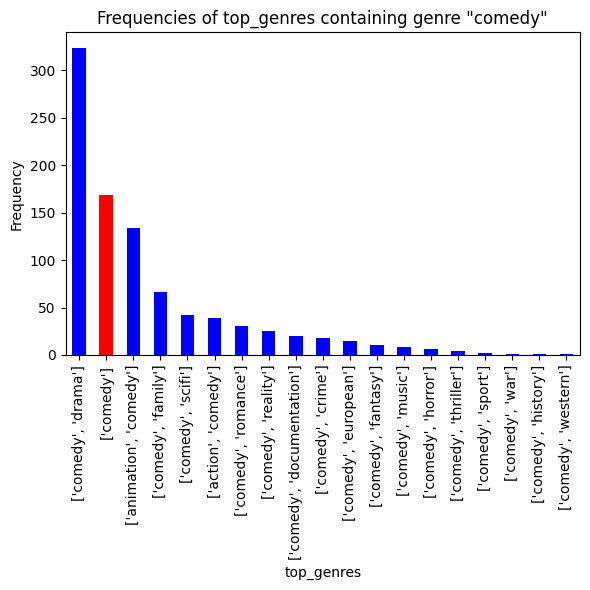

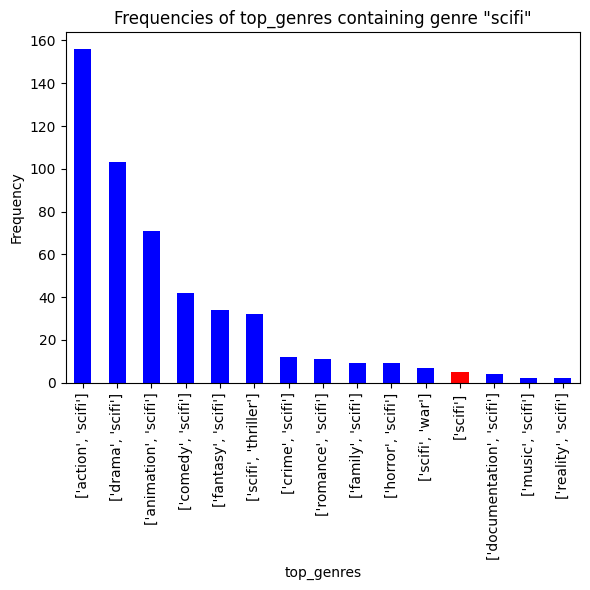

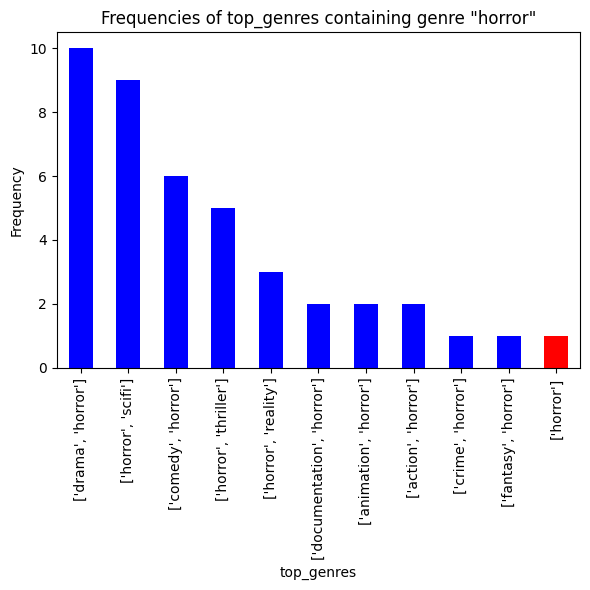

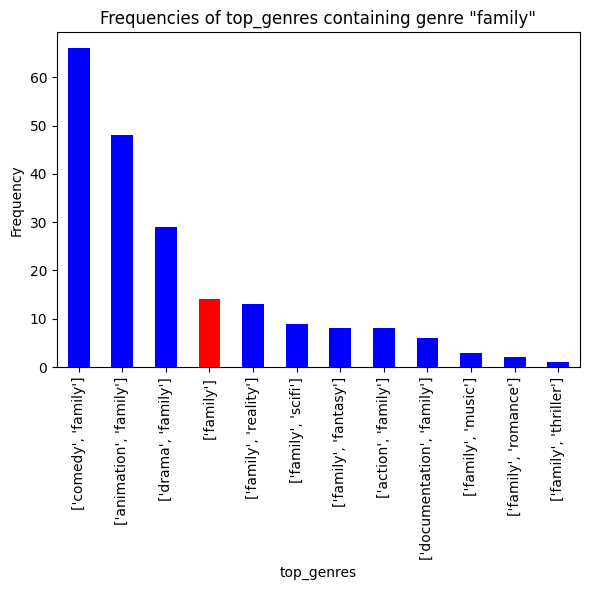

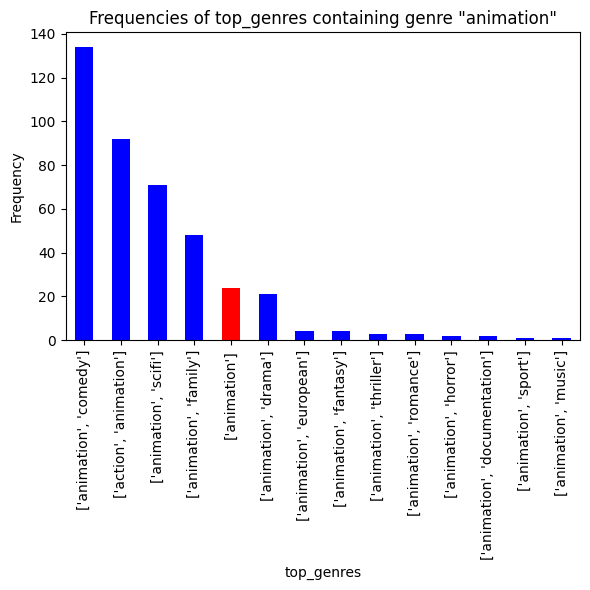

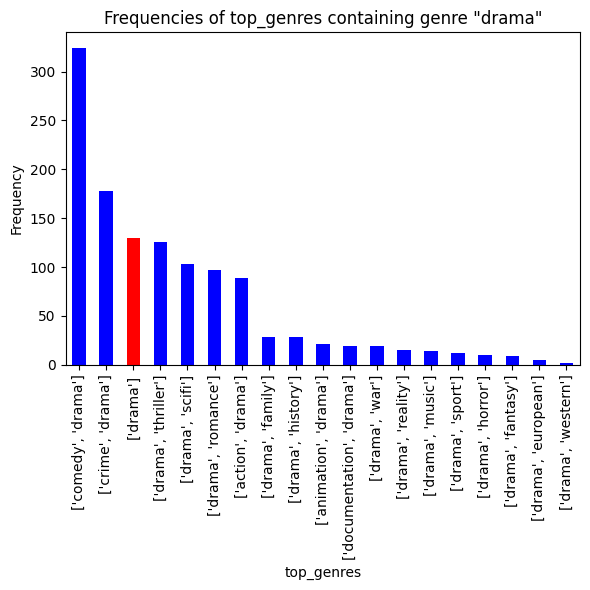

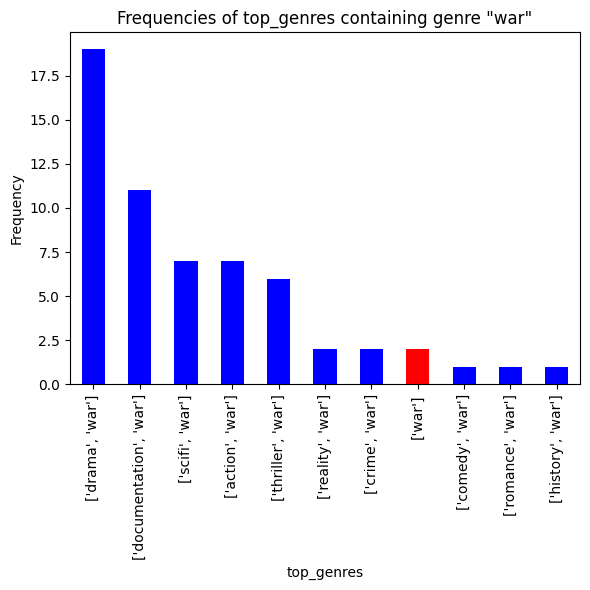

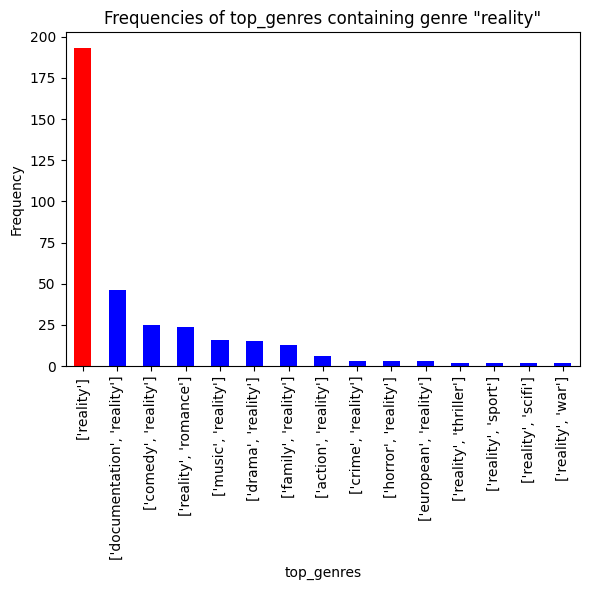

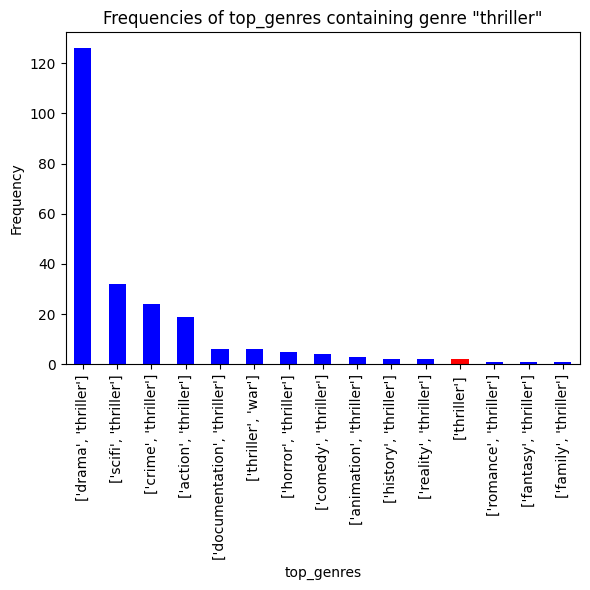

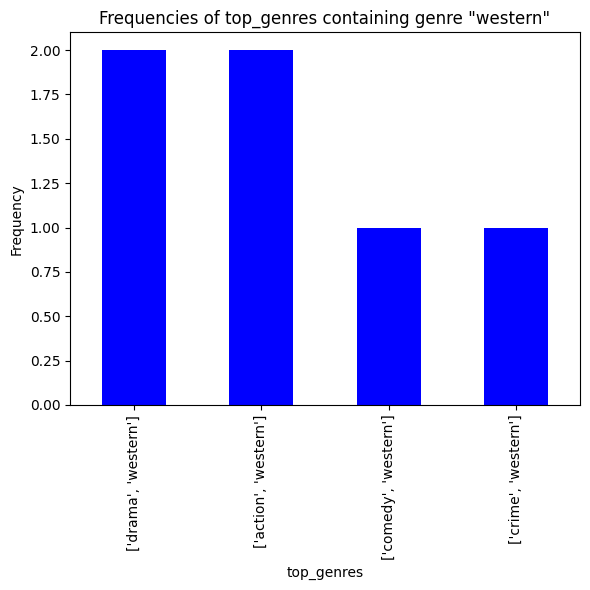

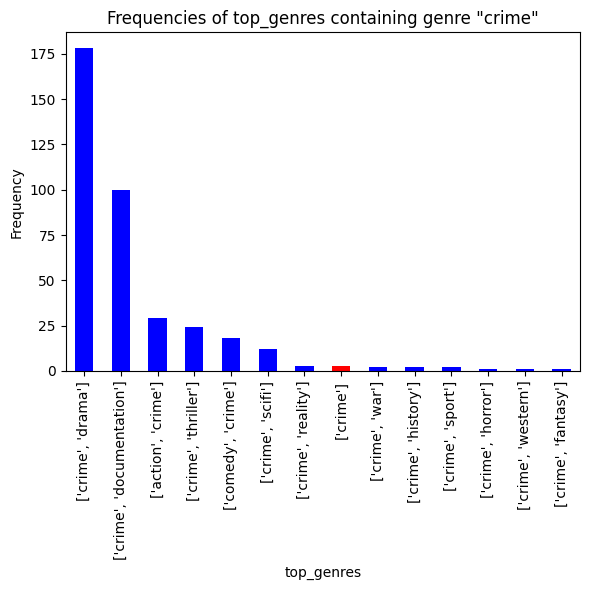

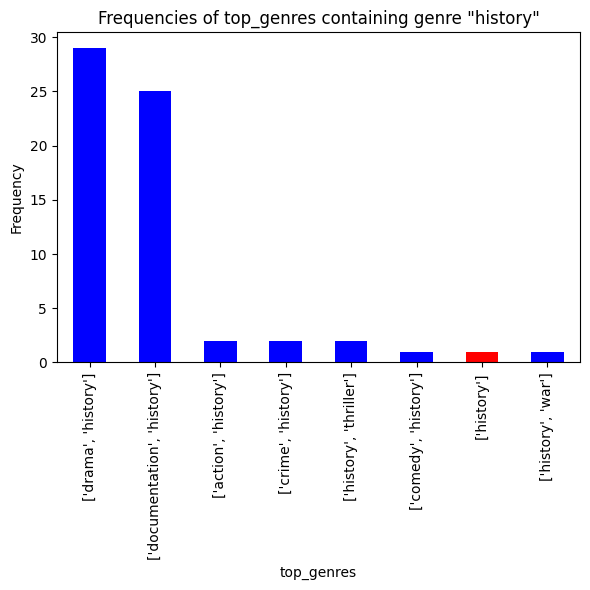

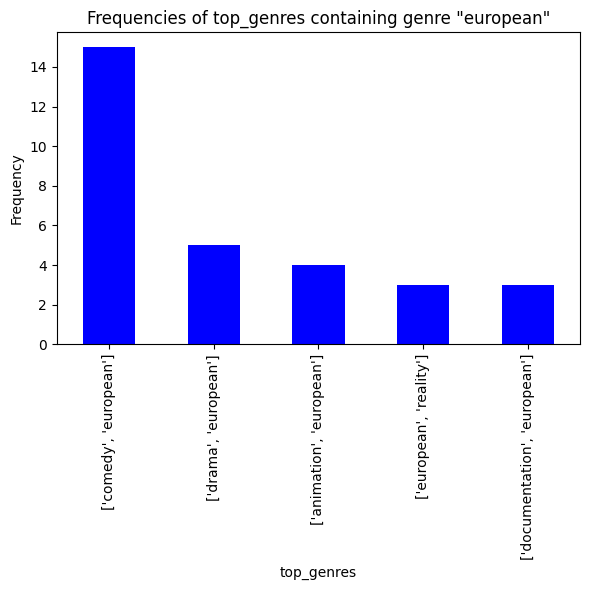

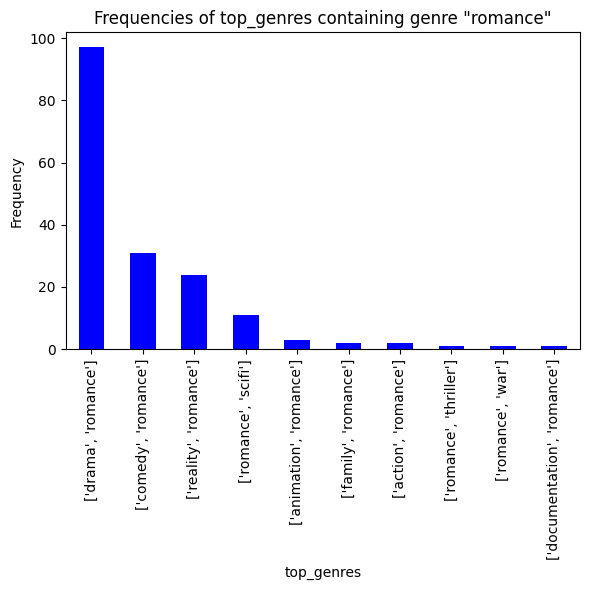

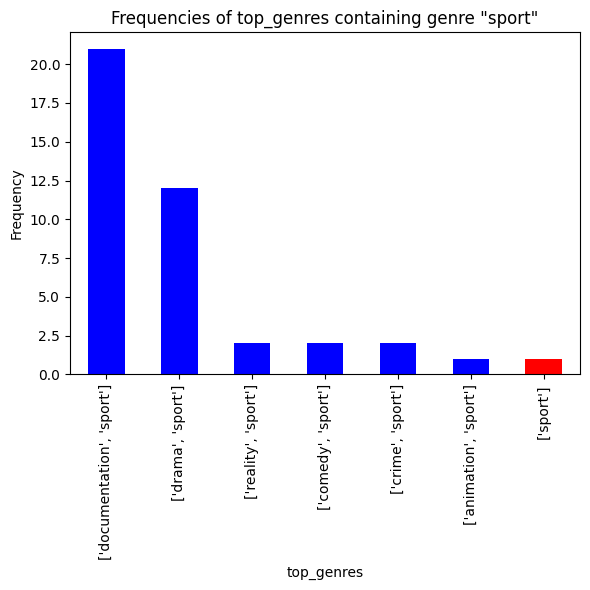

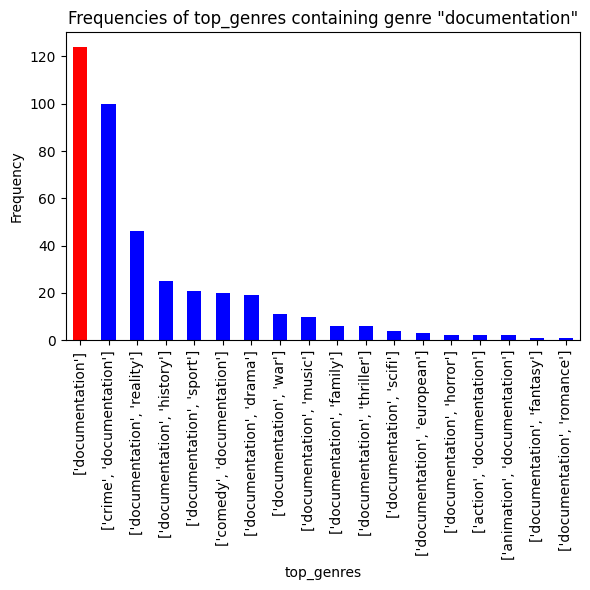

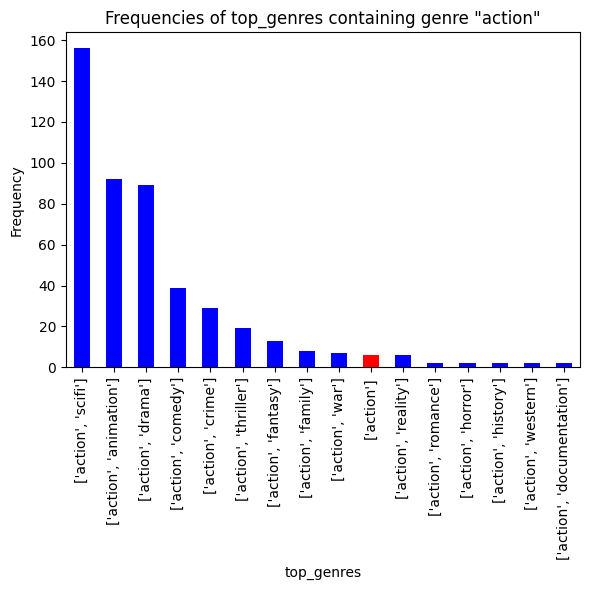

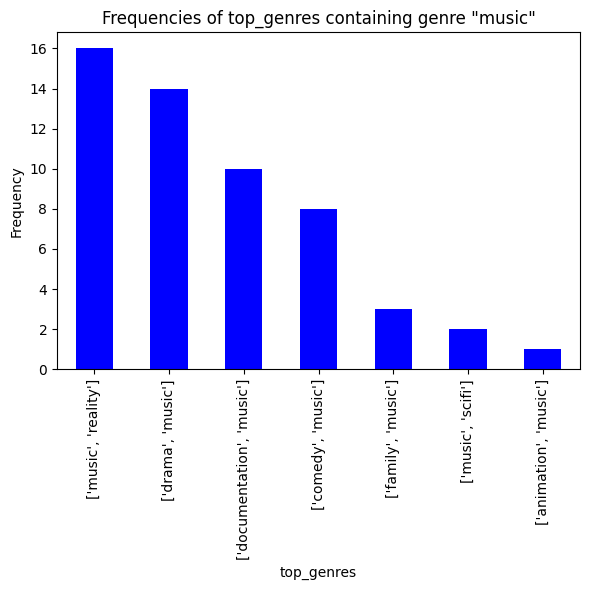

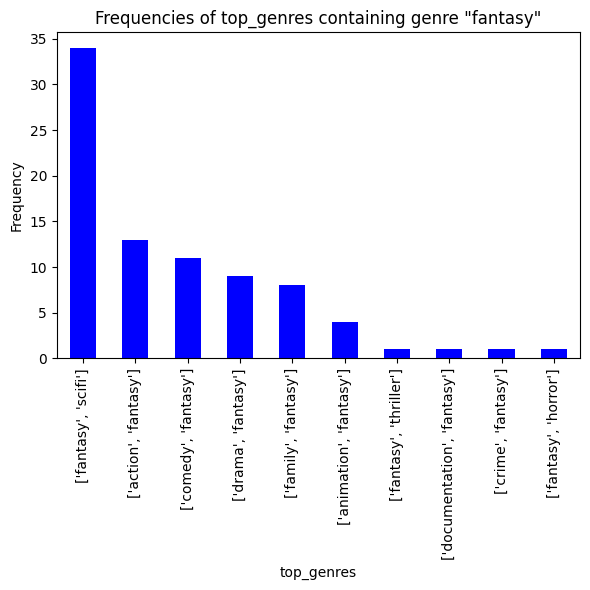

In [23]:
# Plot the frequencies of each genre
for genre in unique_genres:
  plot_genre_frequency(colby_df, target_column, genre)

## Plot average # of seasons for top genres per each unique genre type

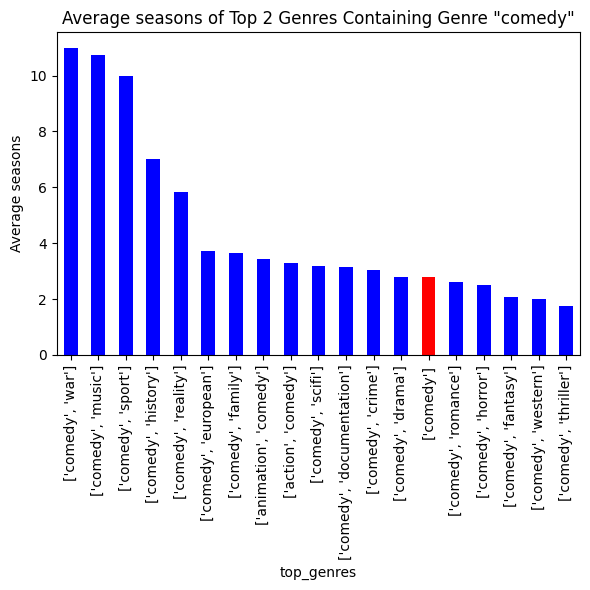

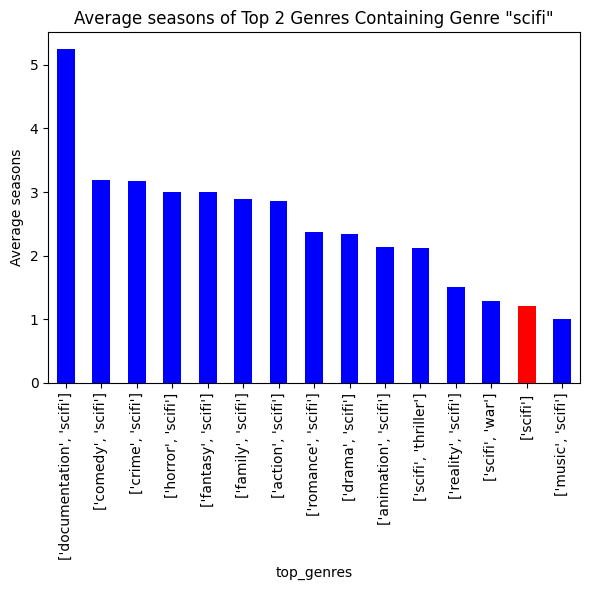

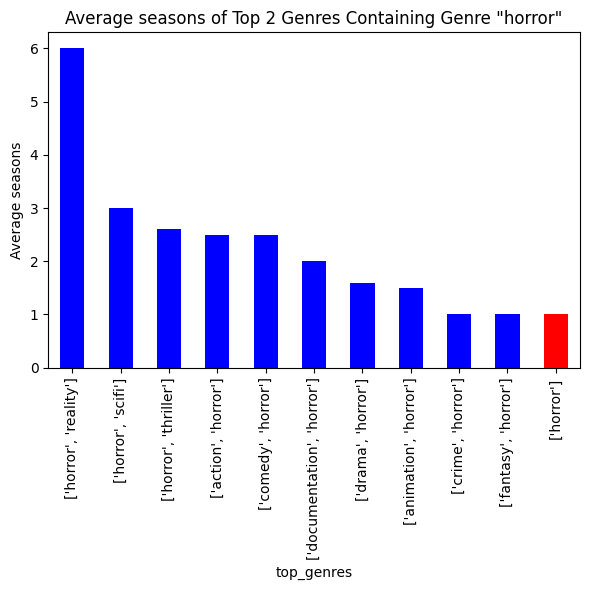

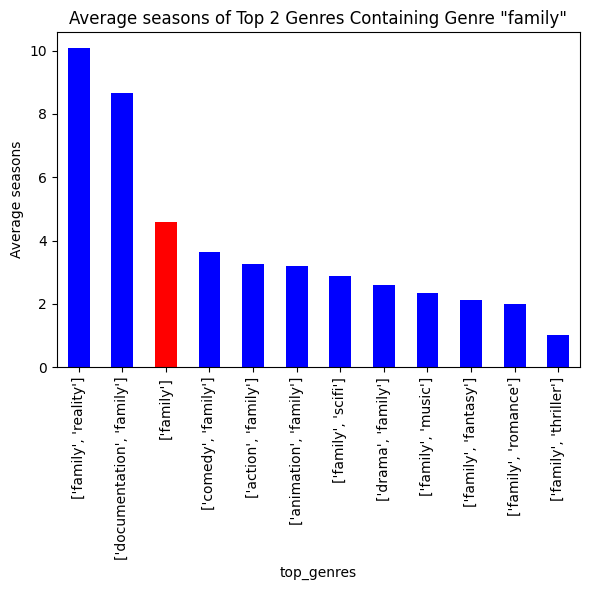

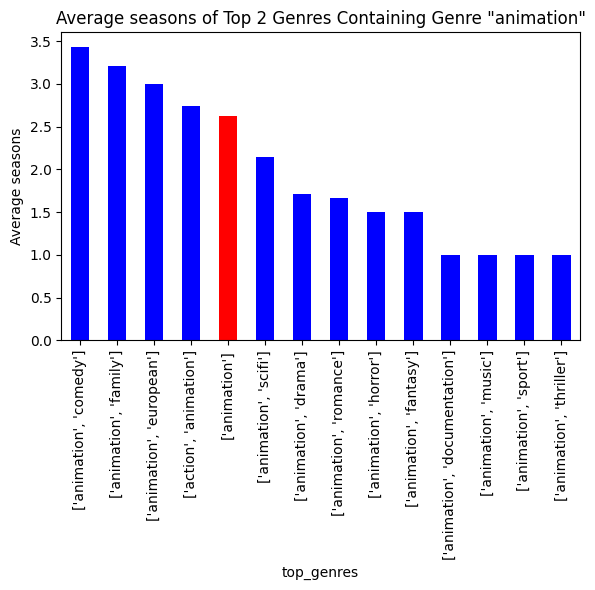

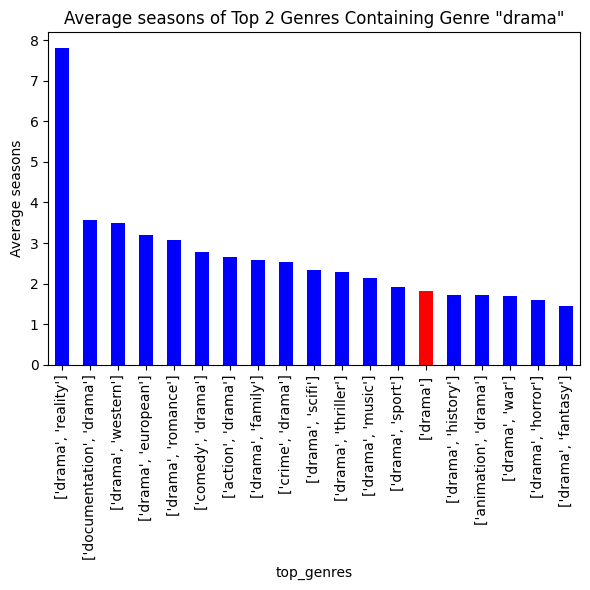

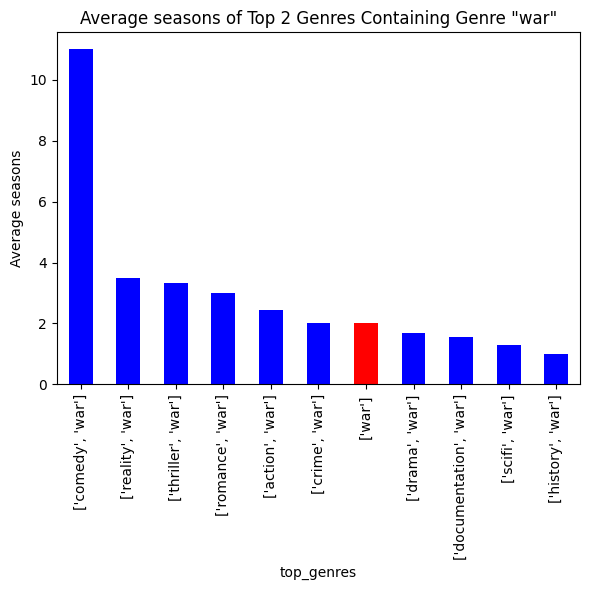

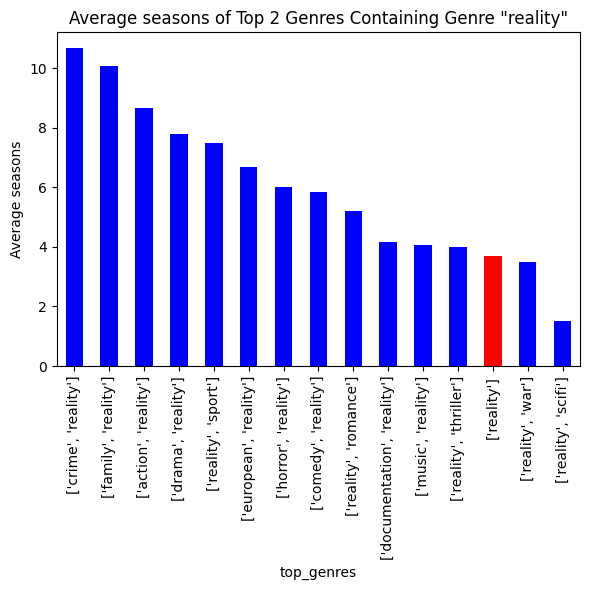

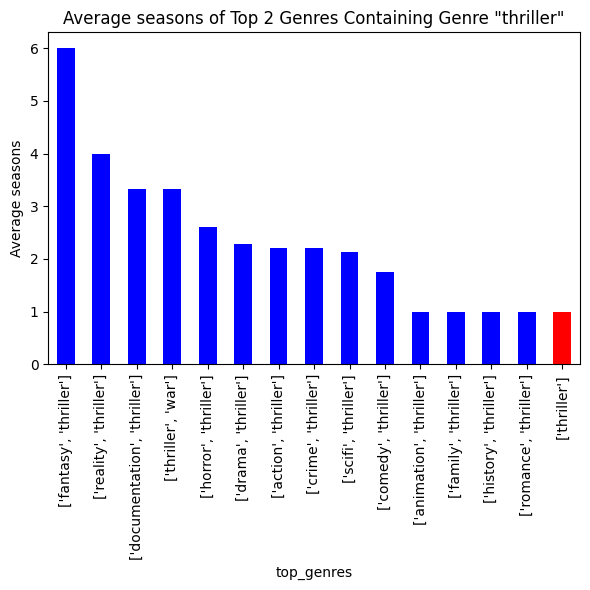

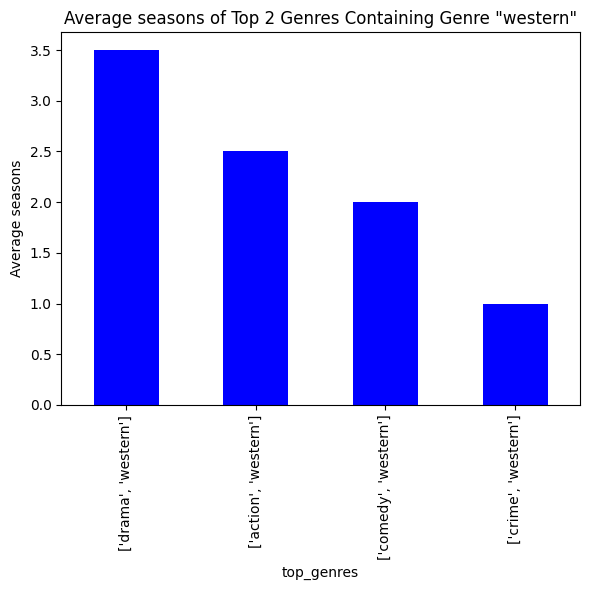

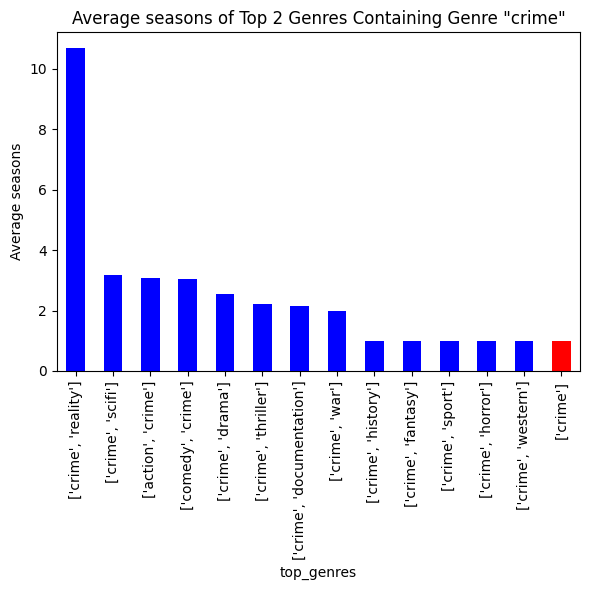

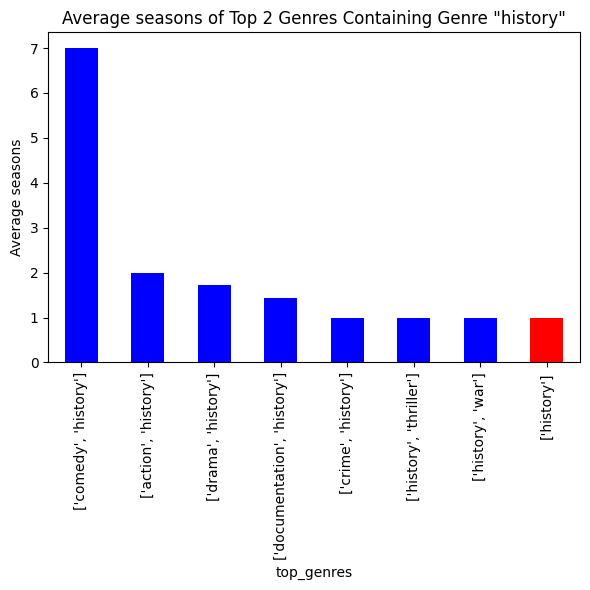

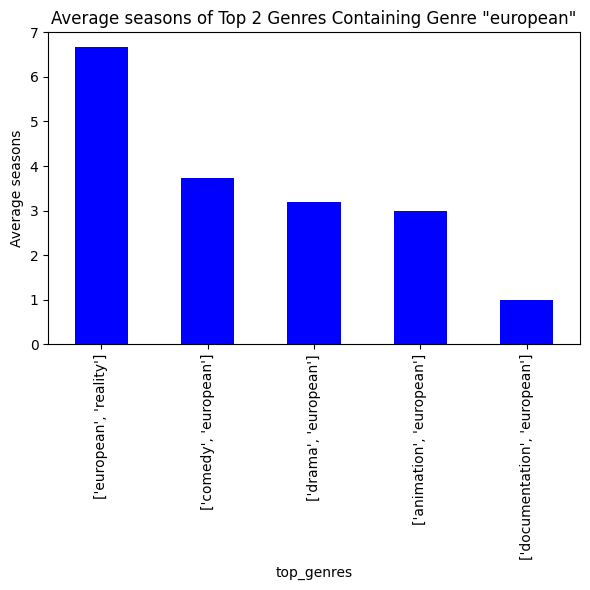

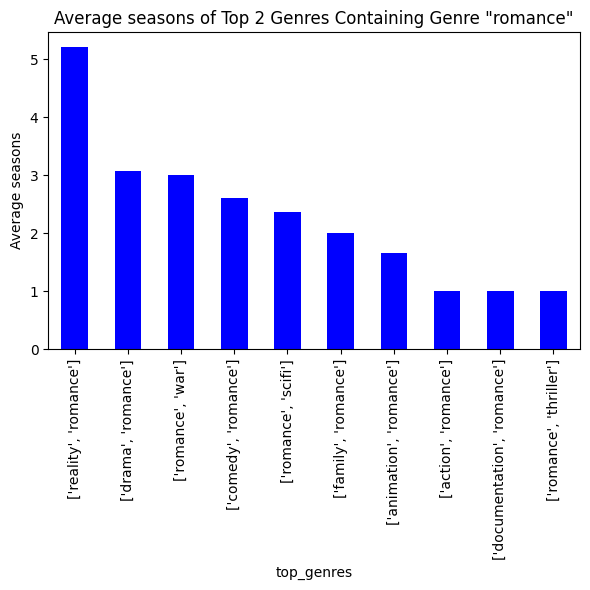

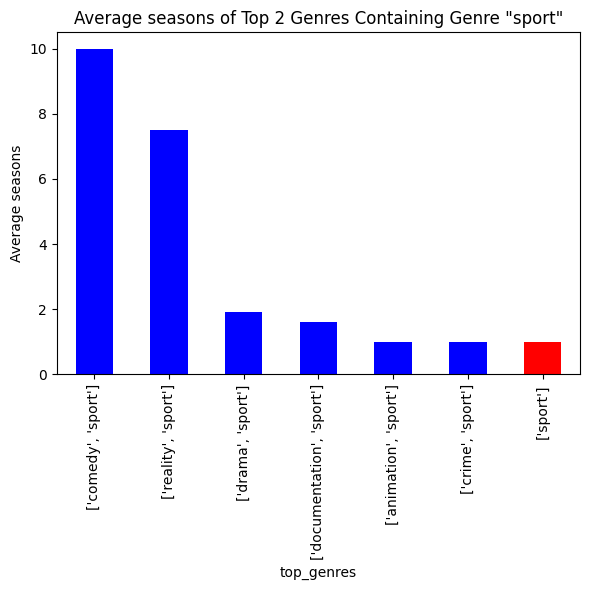

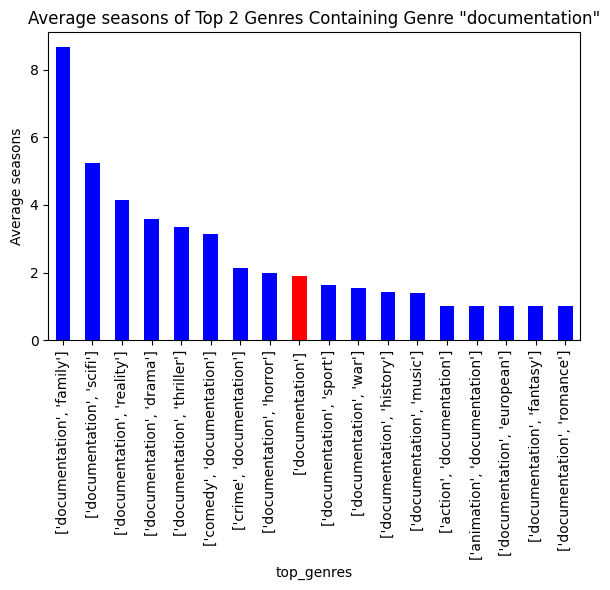

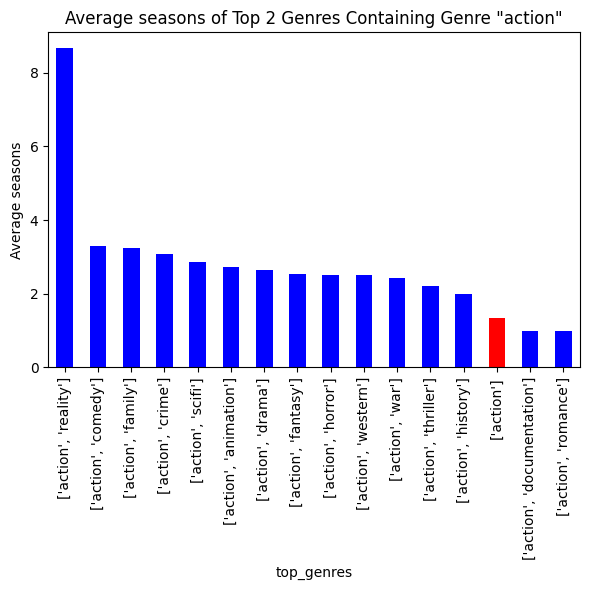

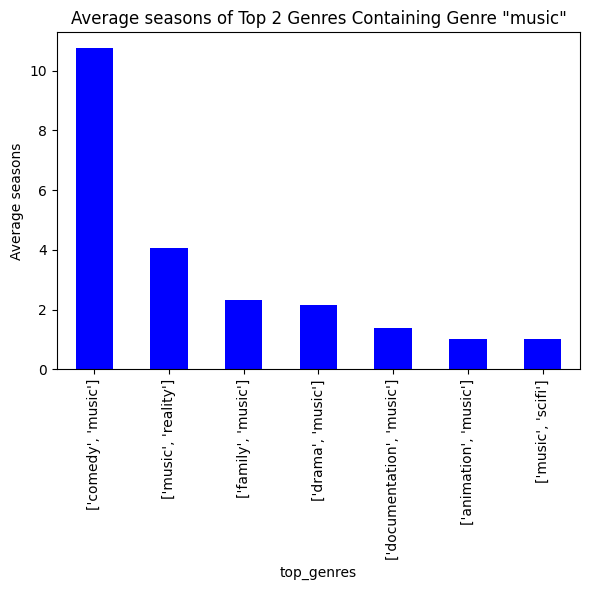

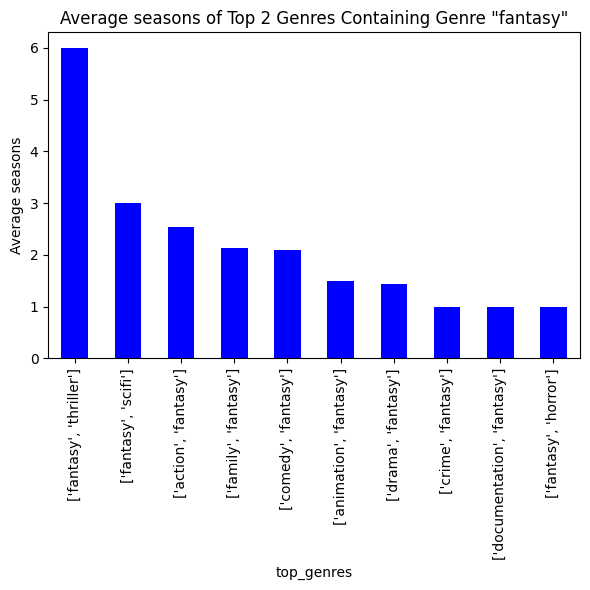

In [34]:
numeric_column = "seasons"

# Plot the average value of 'seasons' for each genre
for genre in unique_genres:
  plot_average_column(colby_df, target_column, genre, numeric_column)

## Plot average of each imdb/tmdb rating column and runtime for top genres per each unique genre type

### Plot imdb_votes

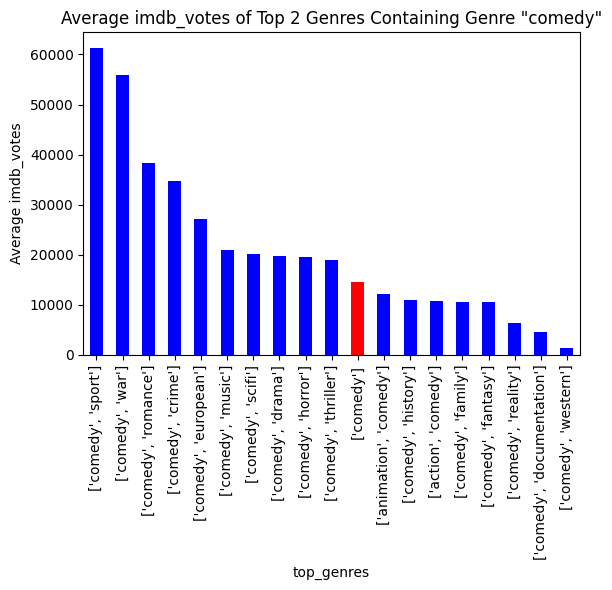

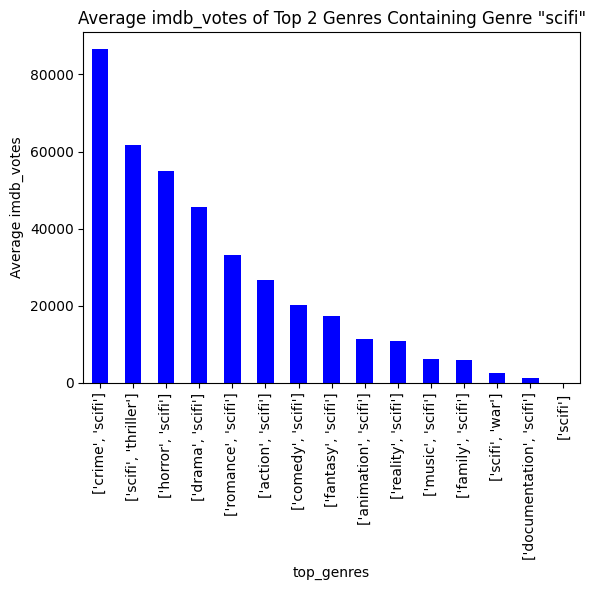

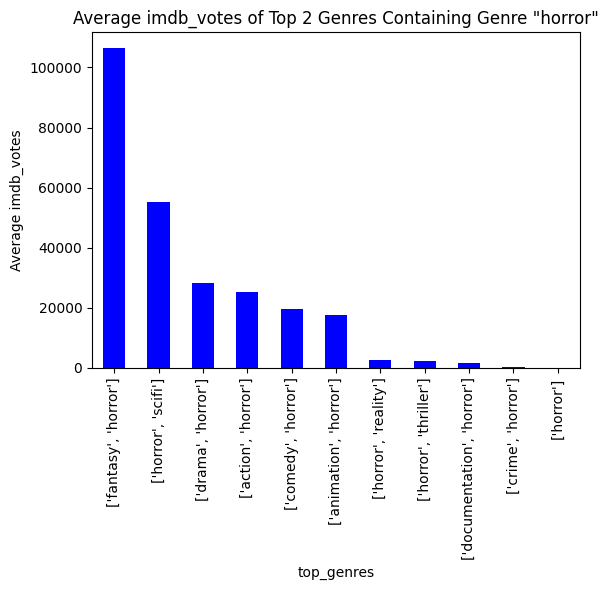

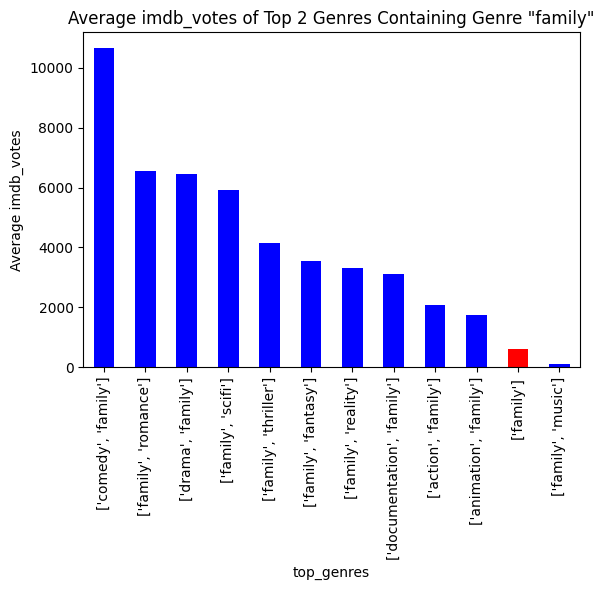

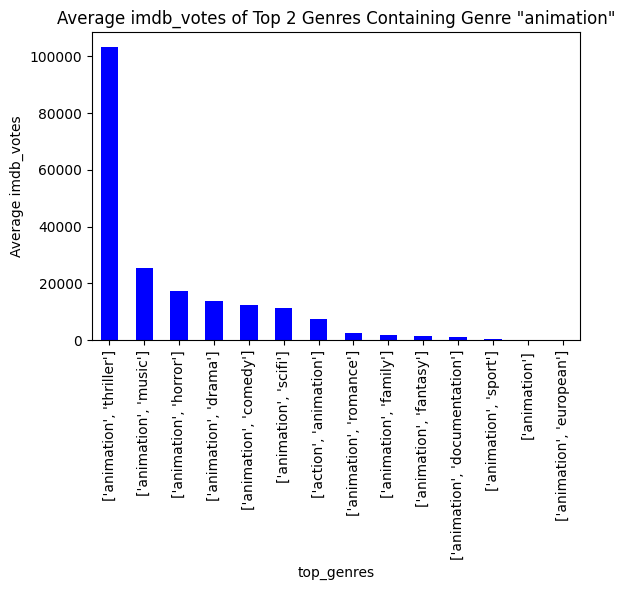

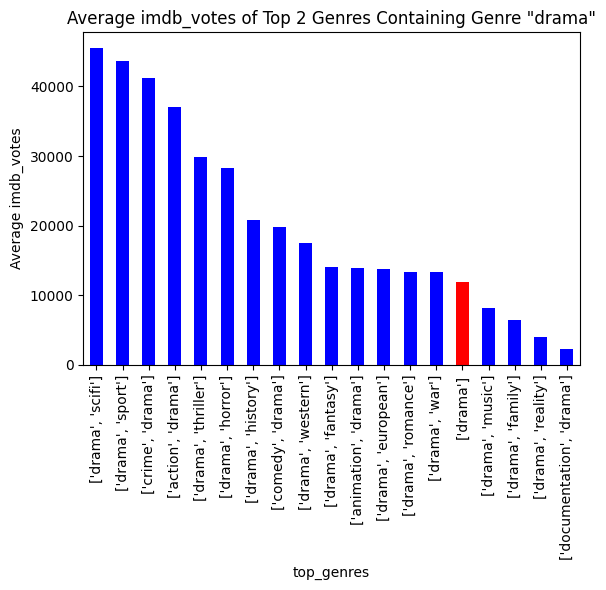

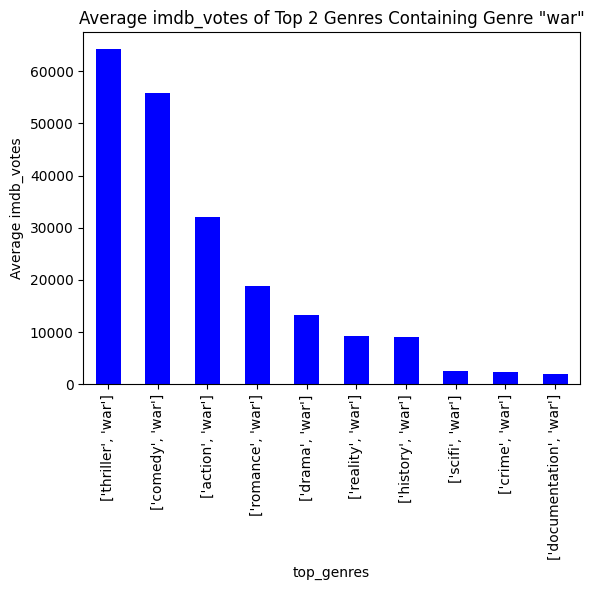

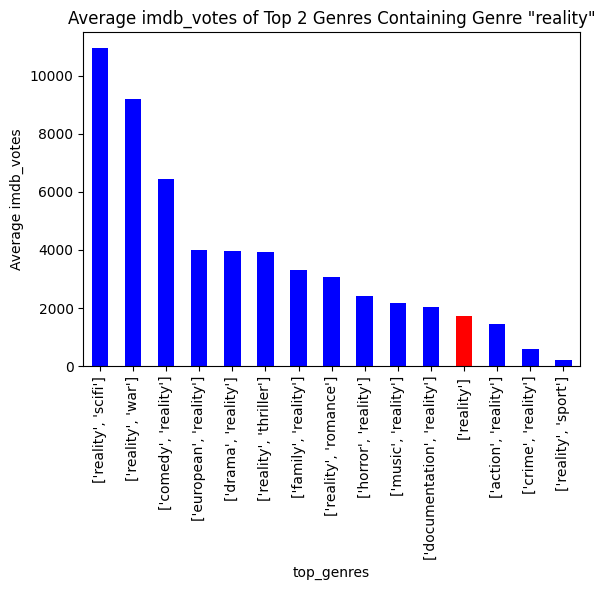

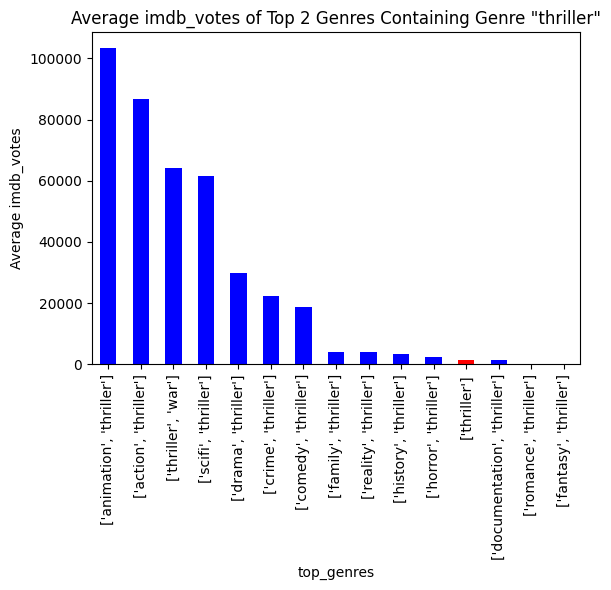

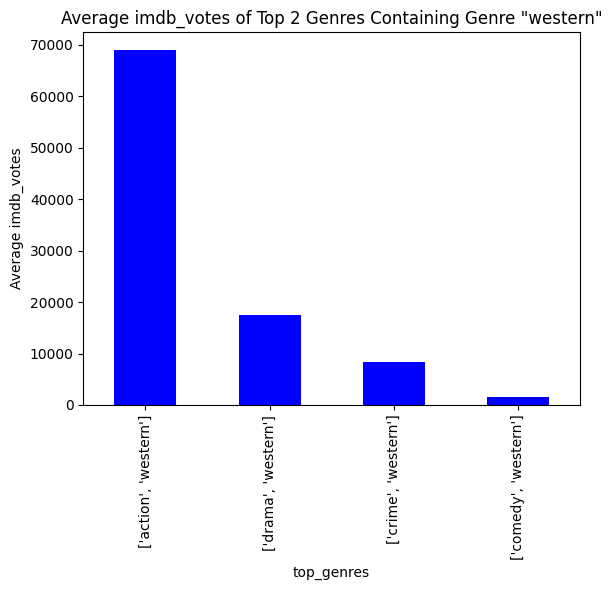

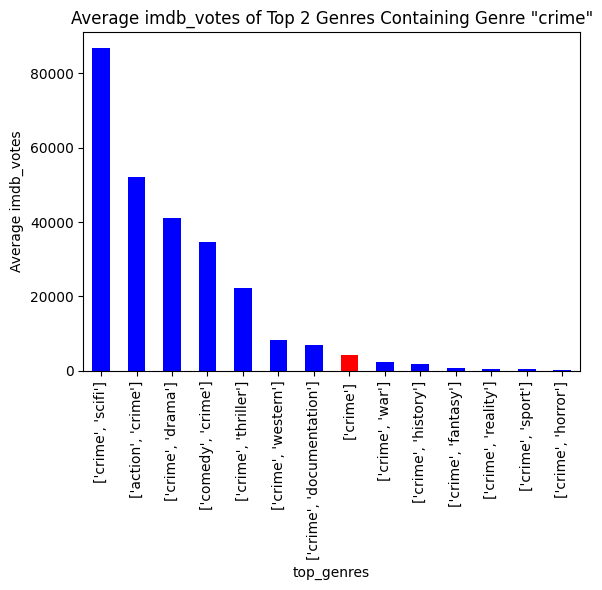

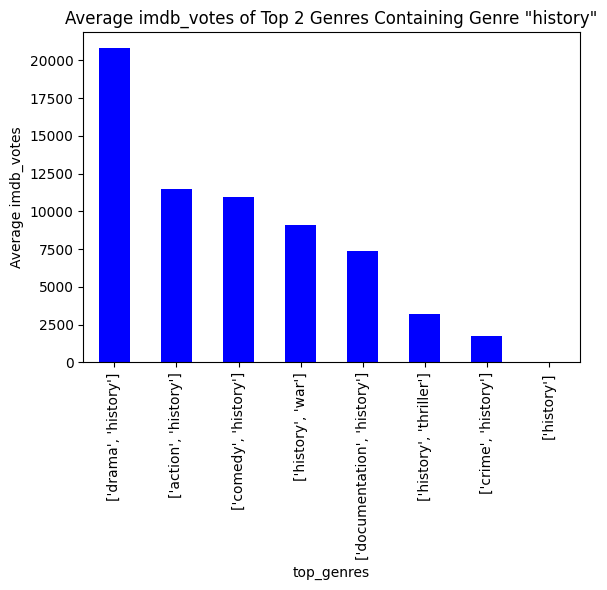

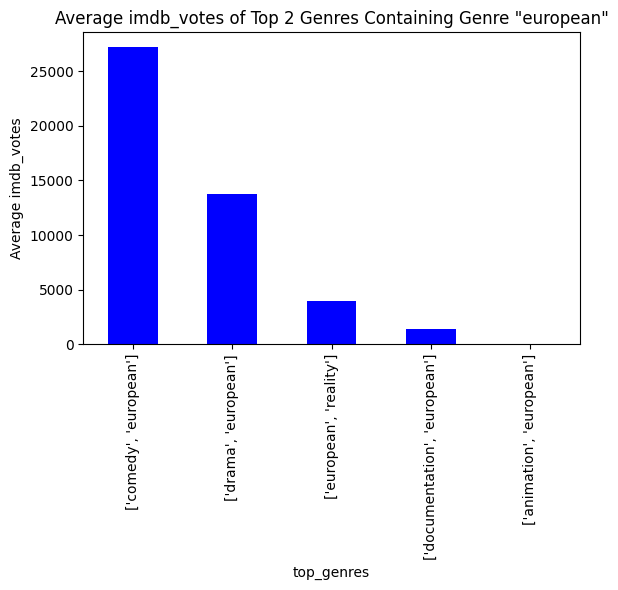

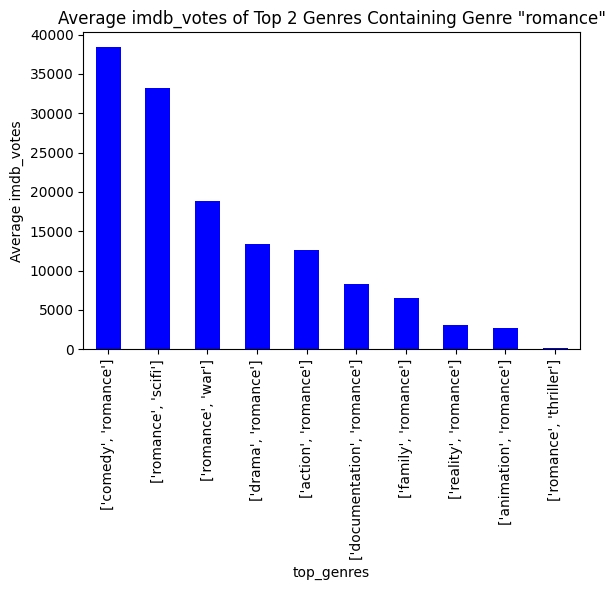

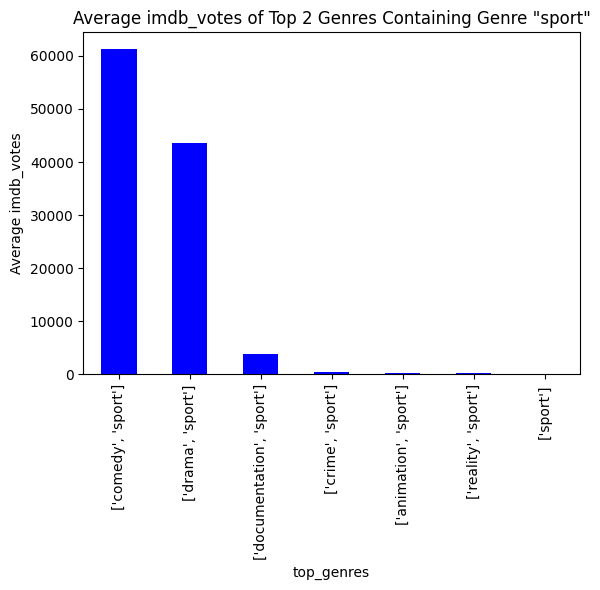

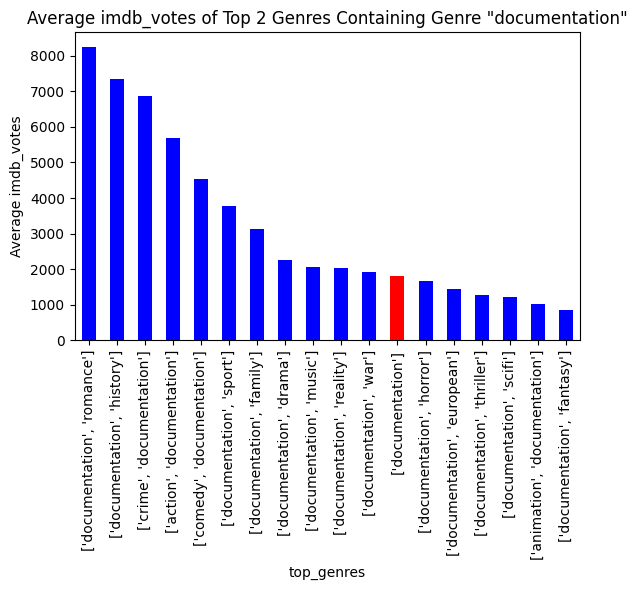

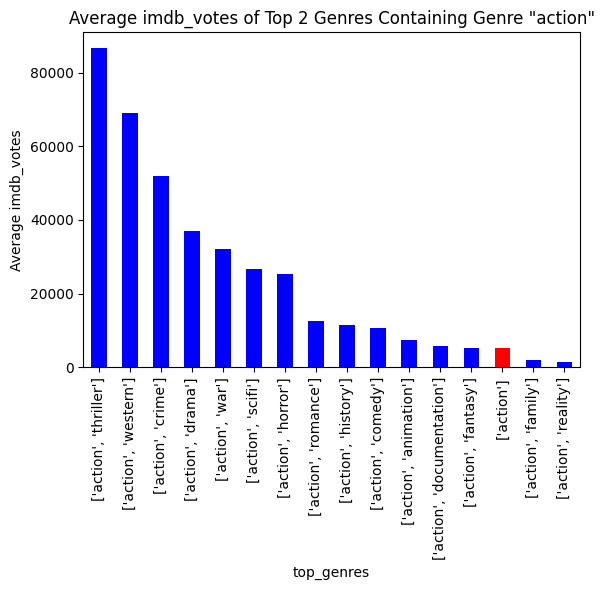

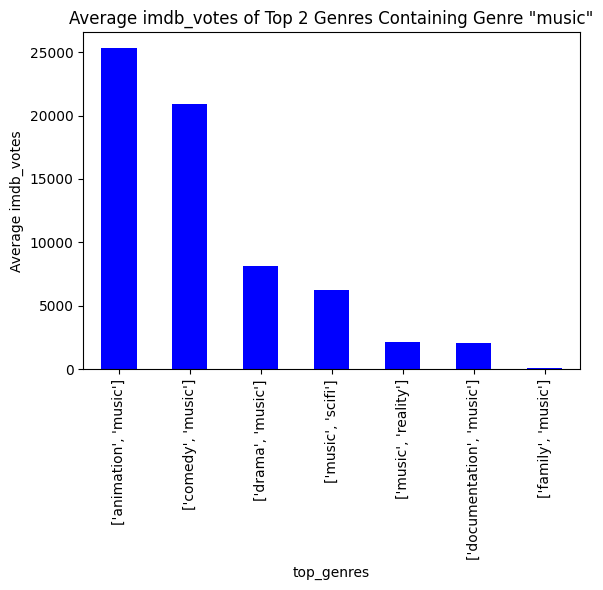

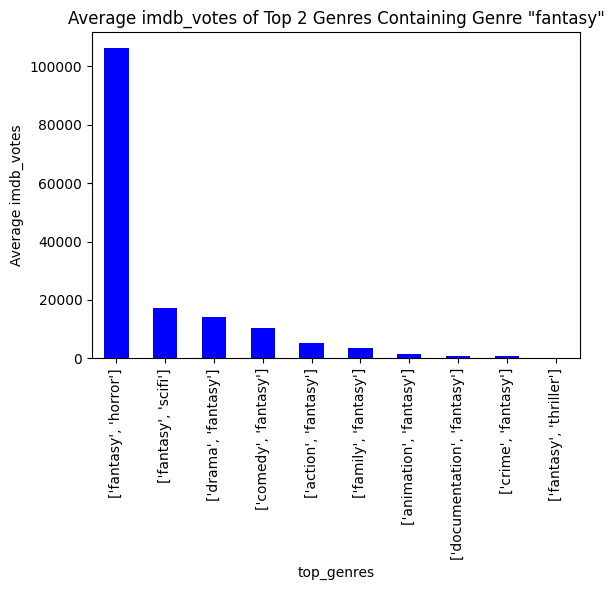

In [25]:
numeric_column = "imdb_votes"

# Plot the average value of 'imdb_votes' for each genre
for genre in unique_genres:
  plot_average_column(colby_df, target_column, genre, numeric_column)

### Plot tmdb_popularity

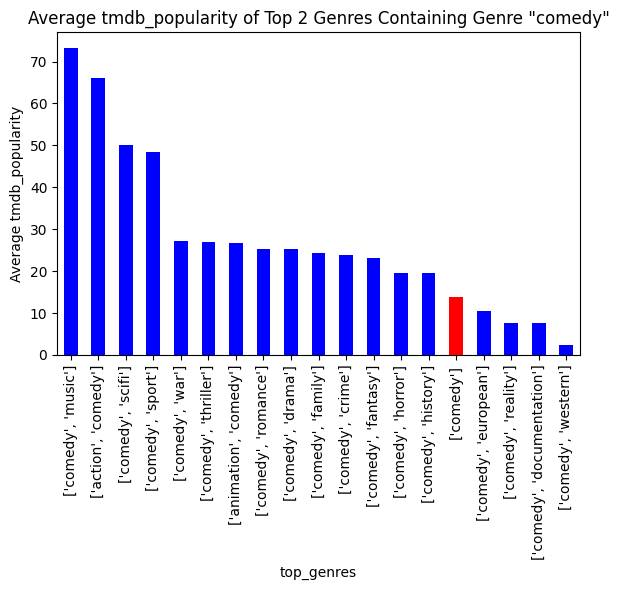

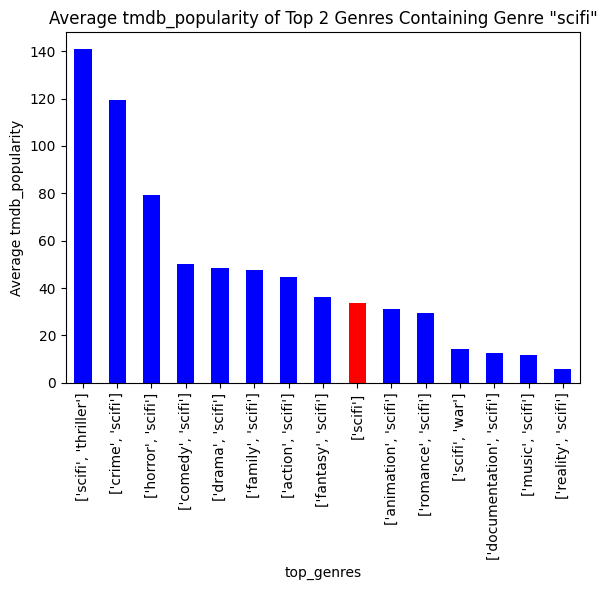

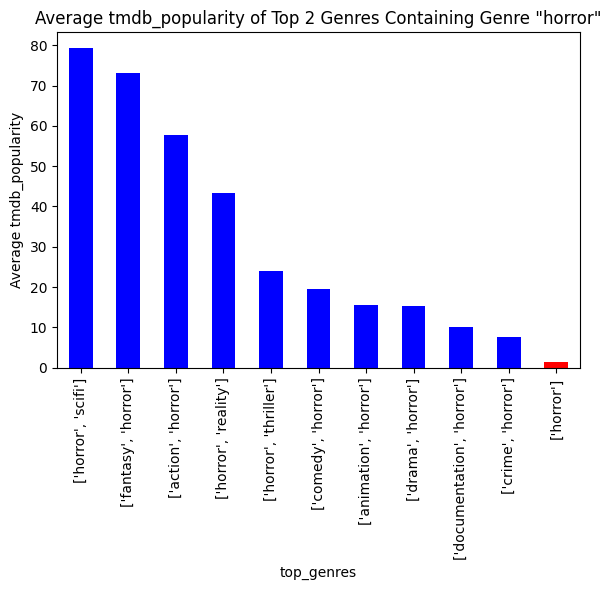

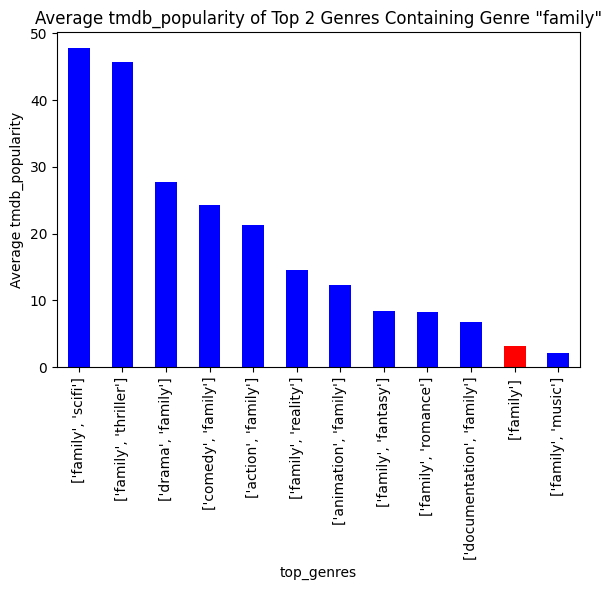

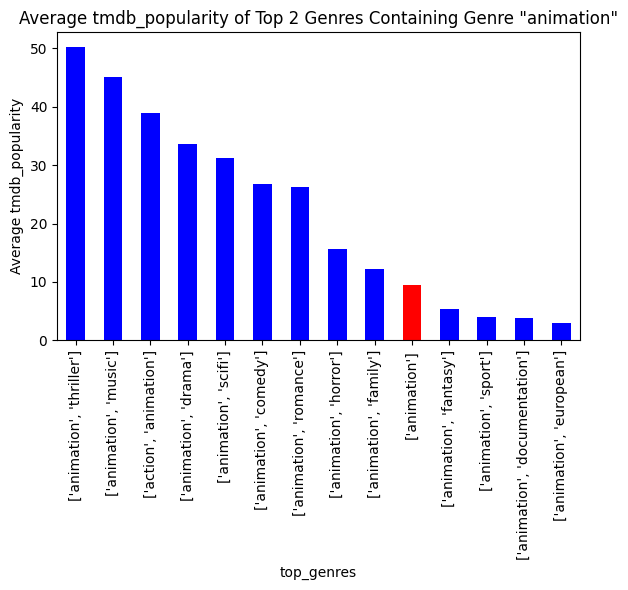

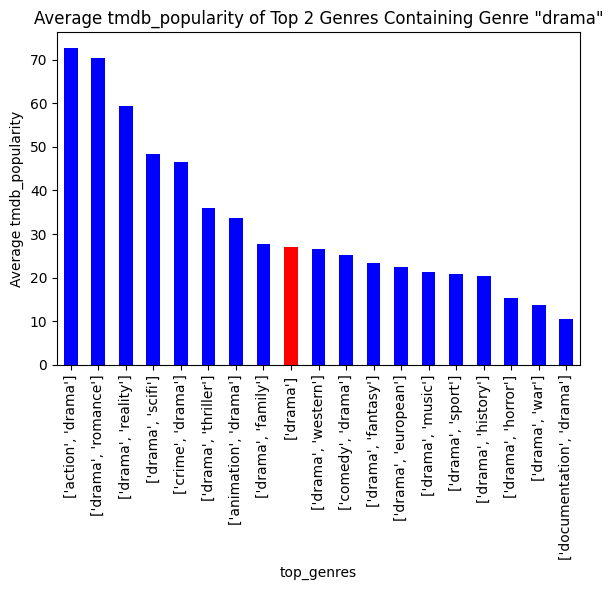

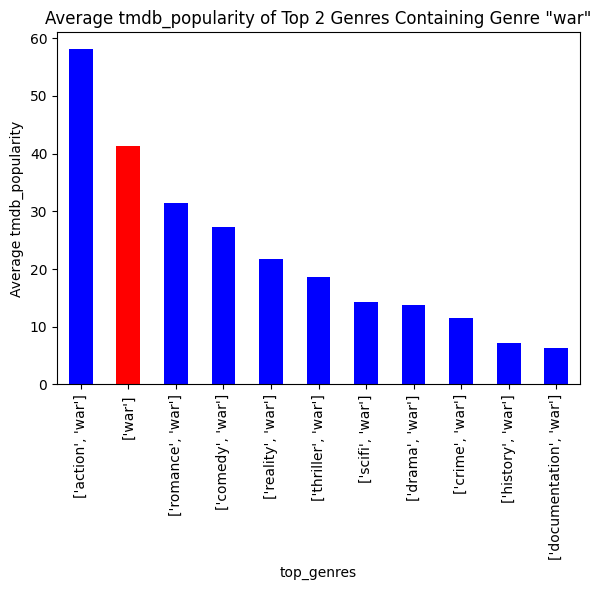

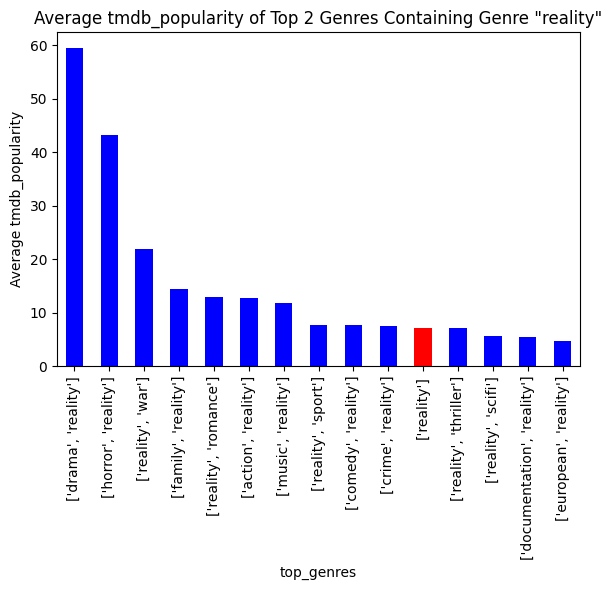

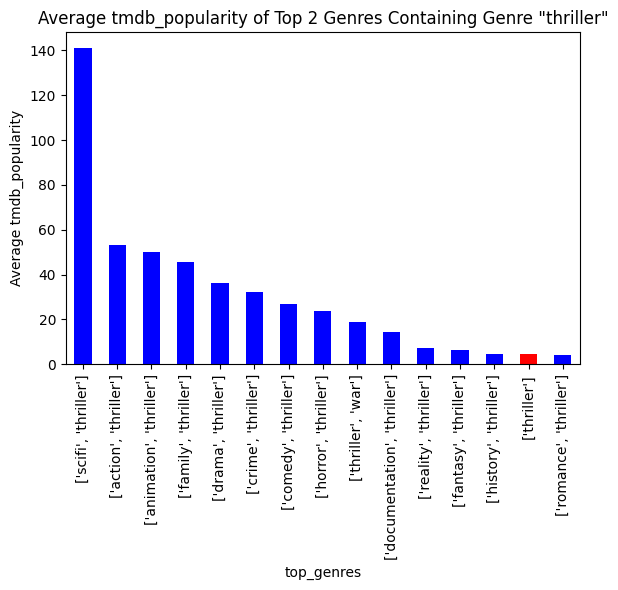

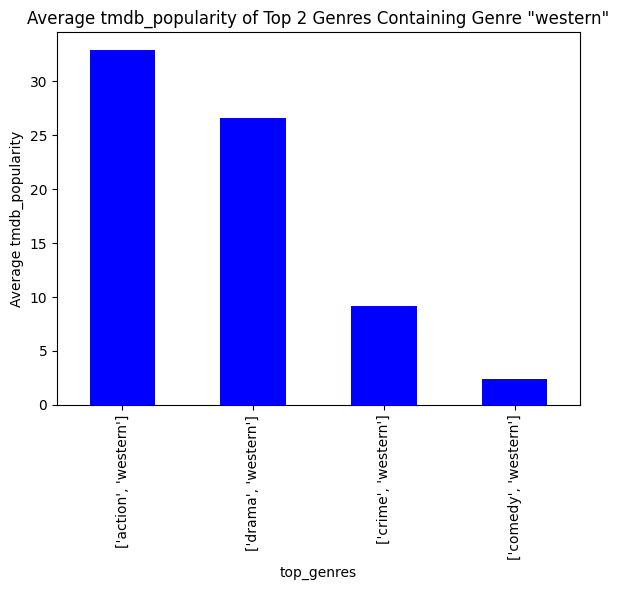

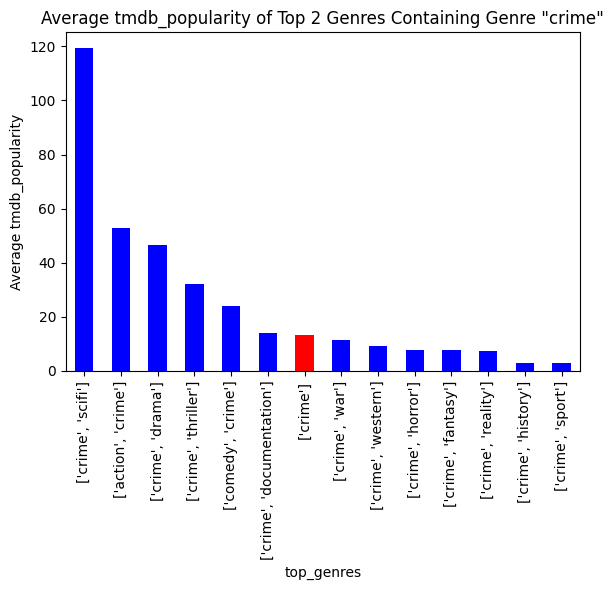

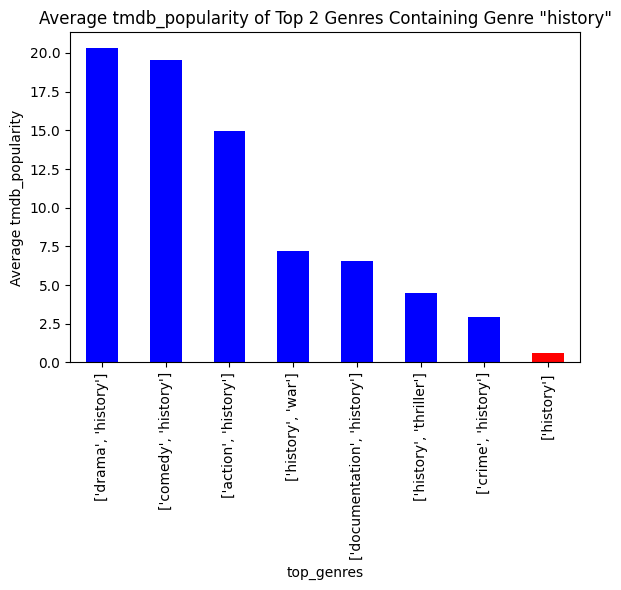

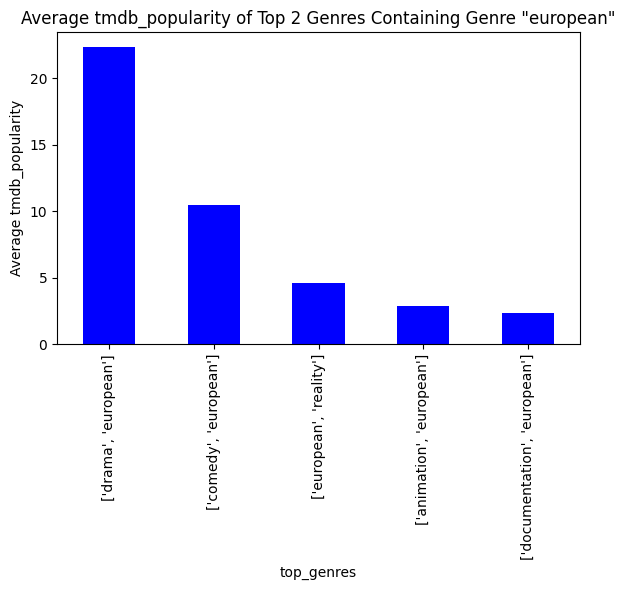

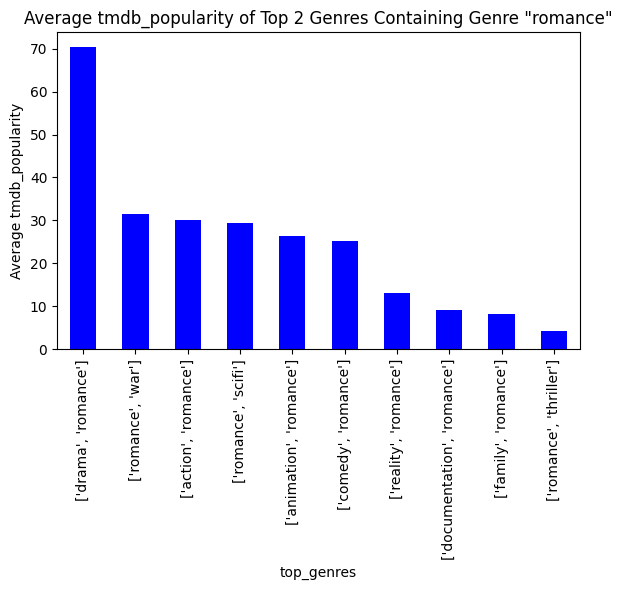

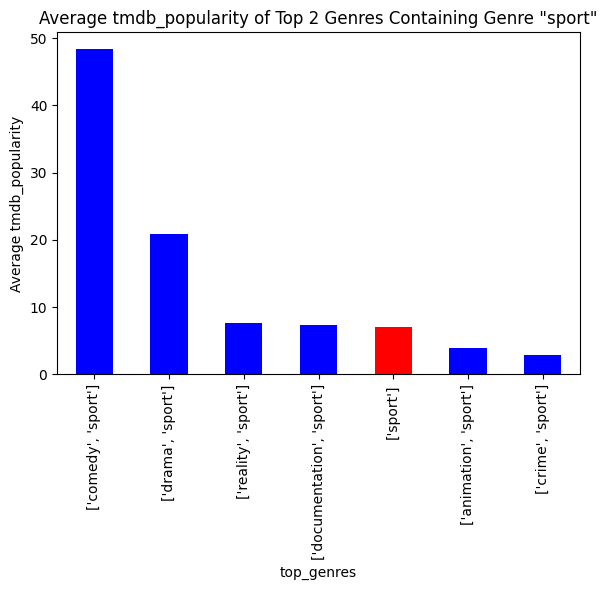

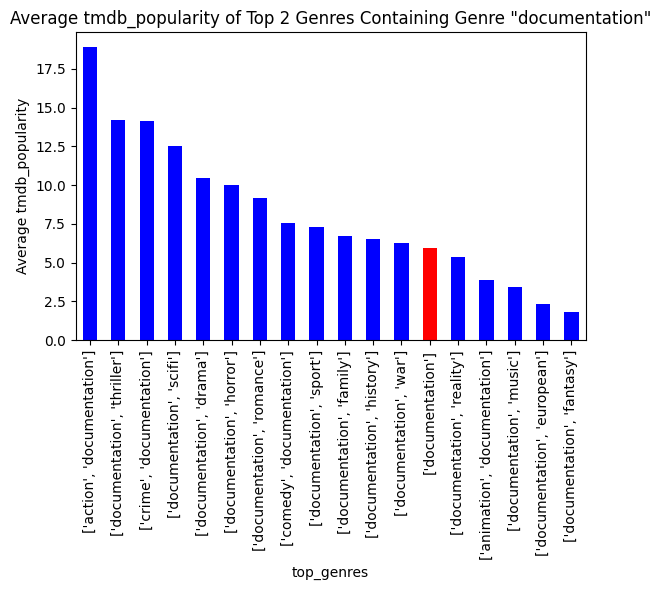

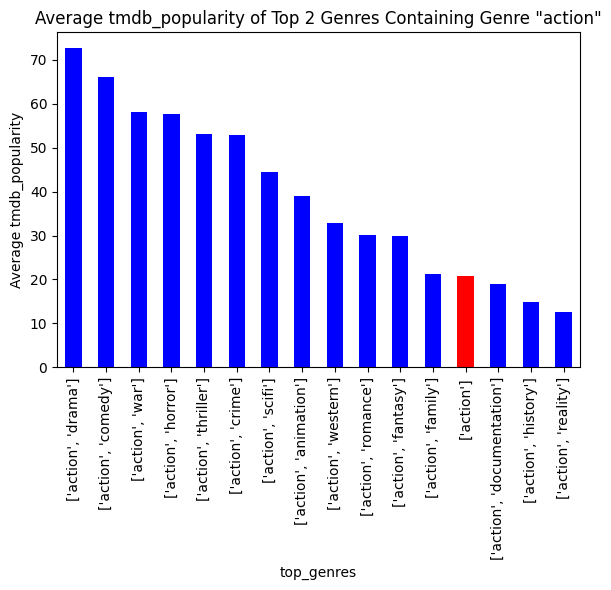

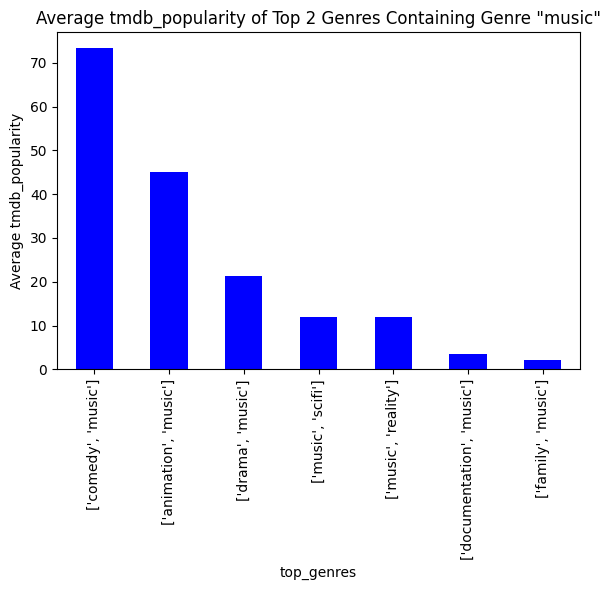

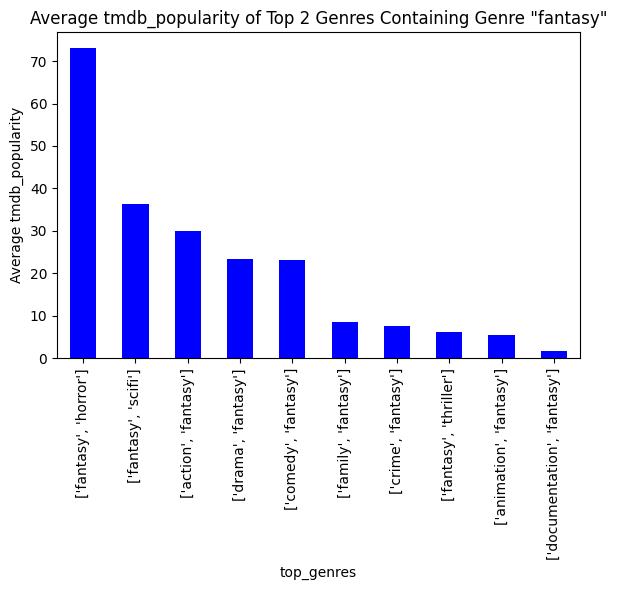

In [37]:
numeric_column = "tmdb_popularity"

# Plot the average value of 'tmdb_popularity' for each genre
for genre in unique_genres:
  plot_average_column(colby_df, target_column, genre, numeric_column)

### Plot average_score

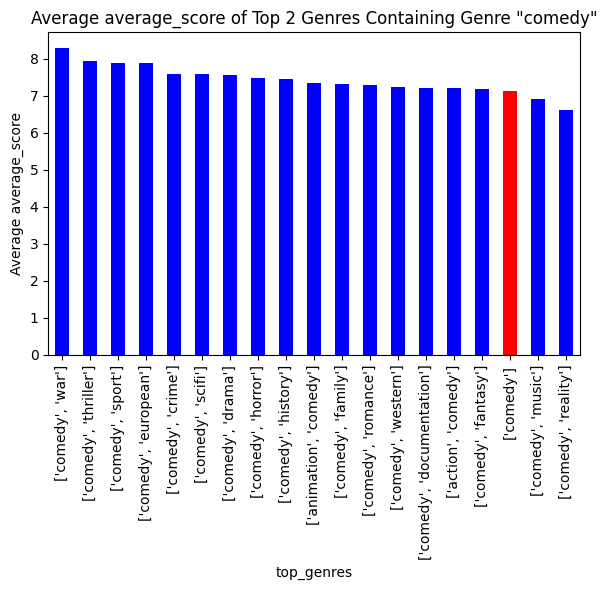

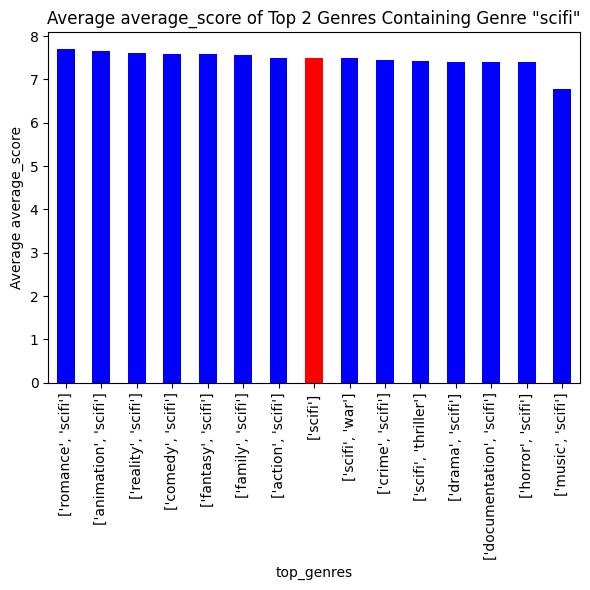

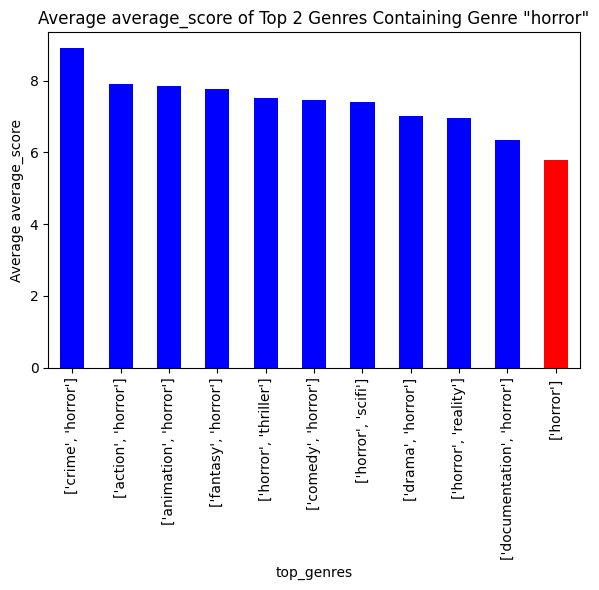

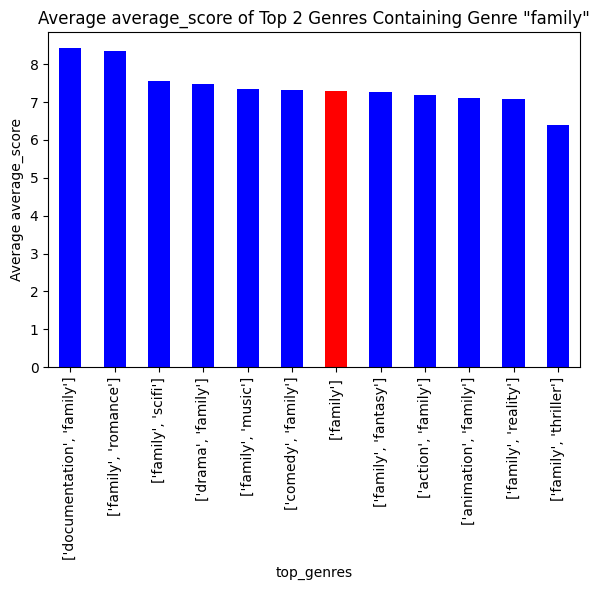

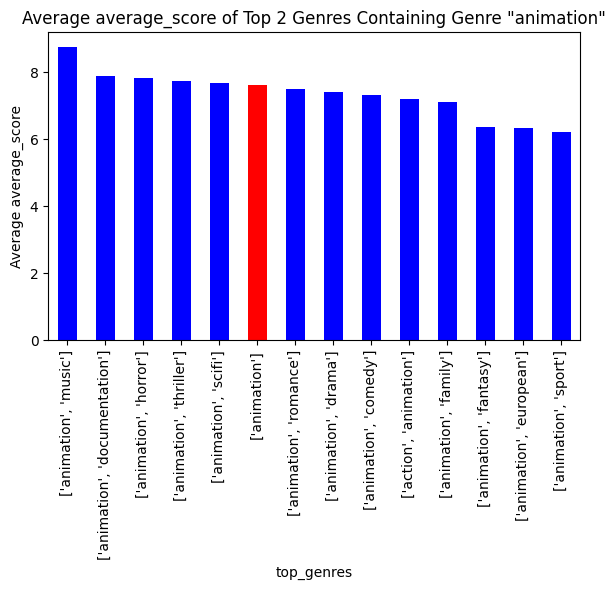

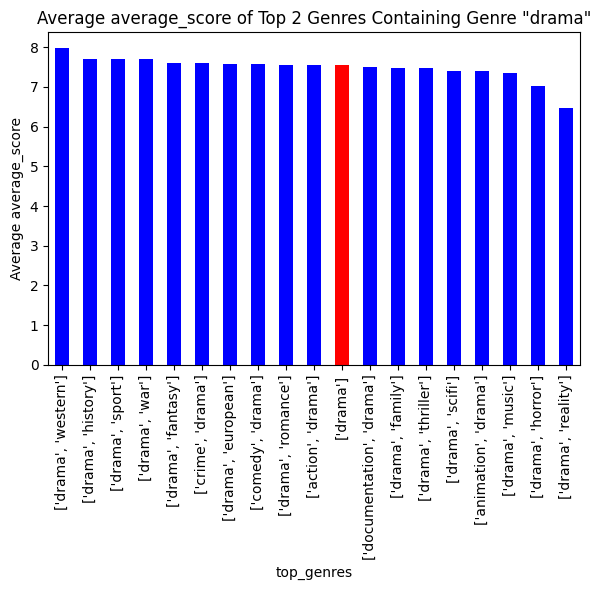

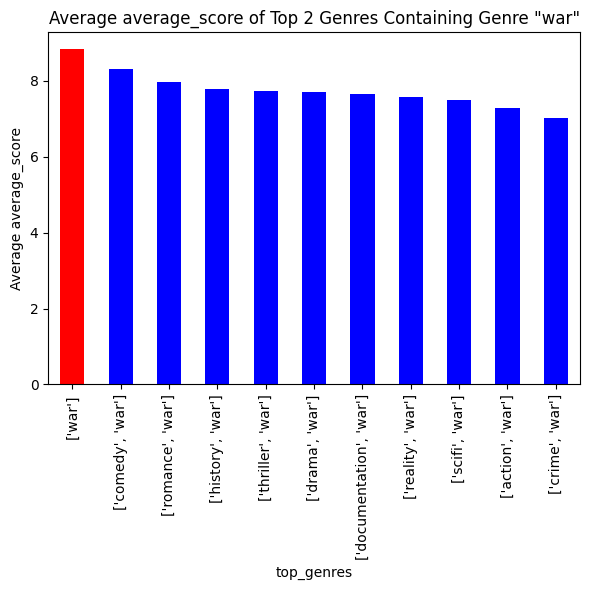

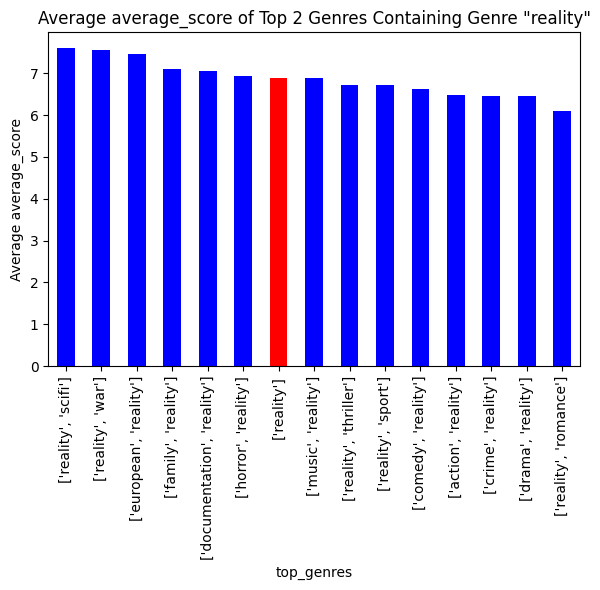

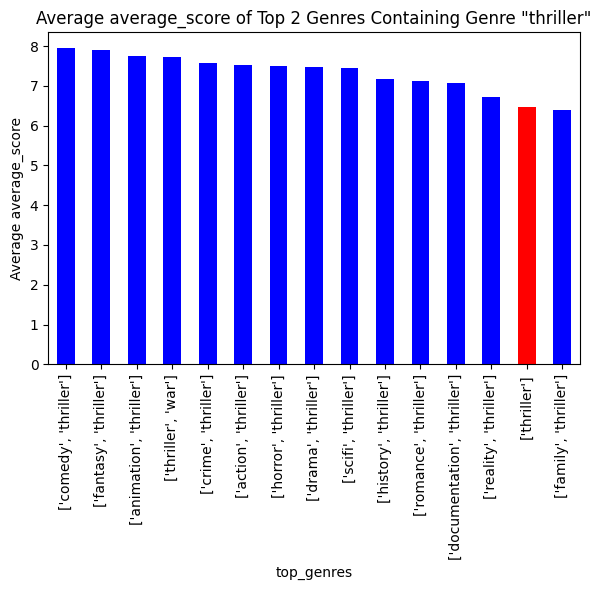

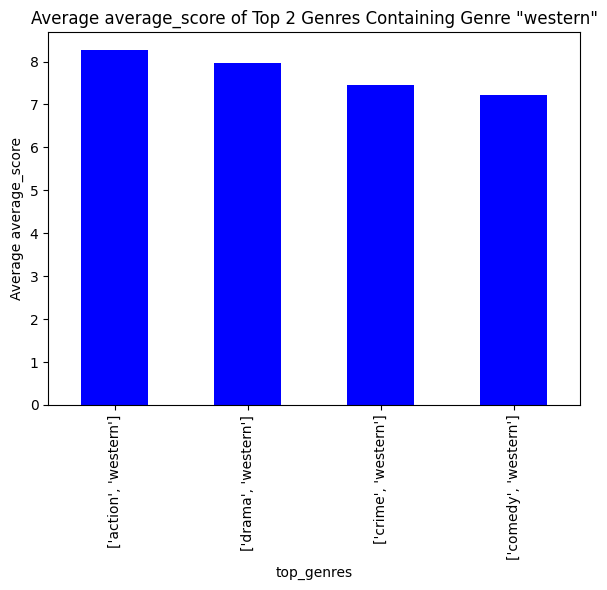

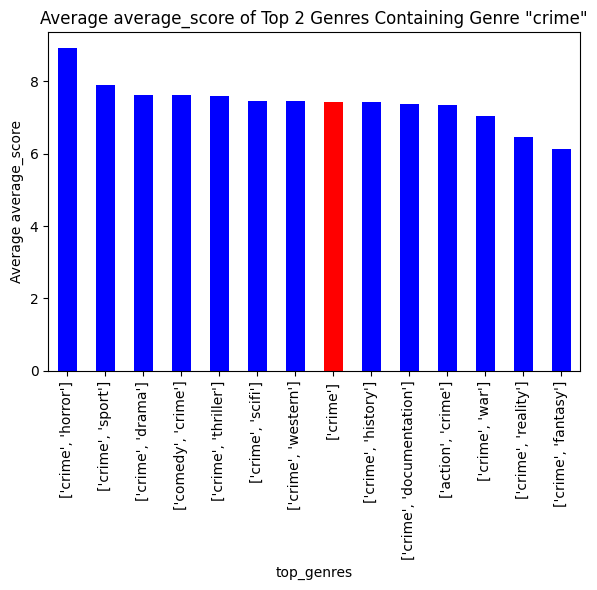

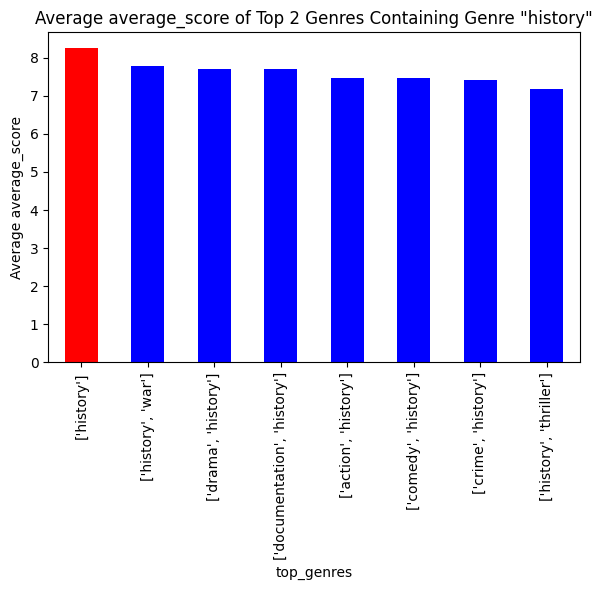

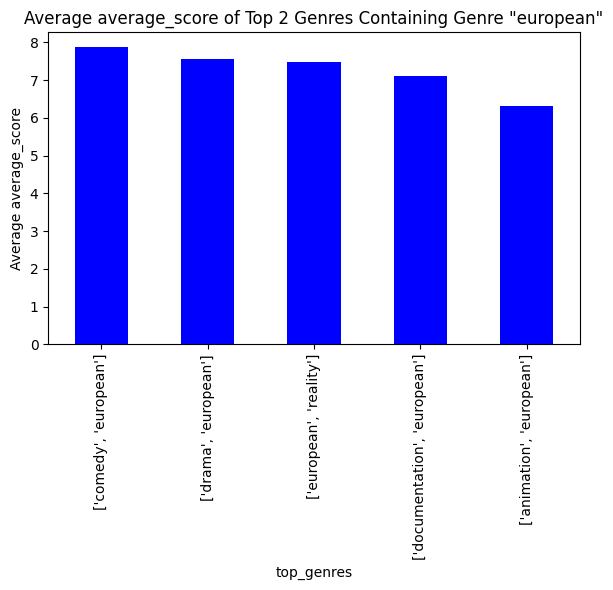

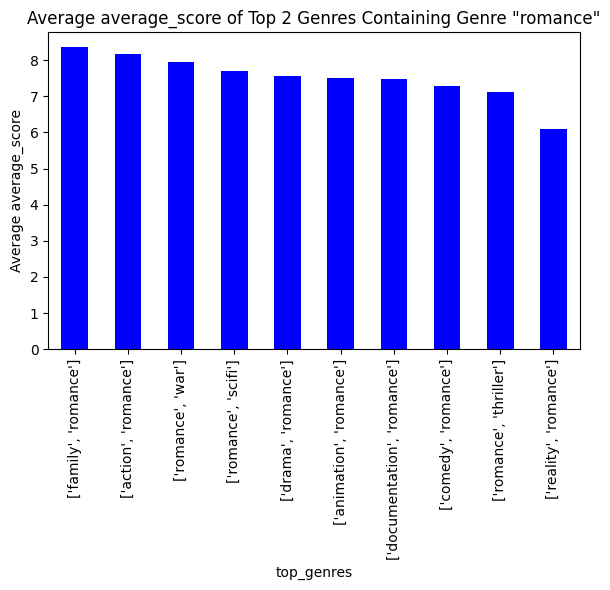

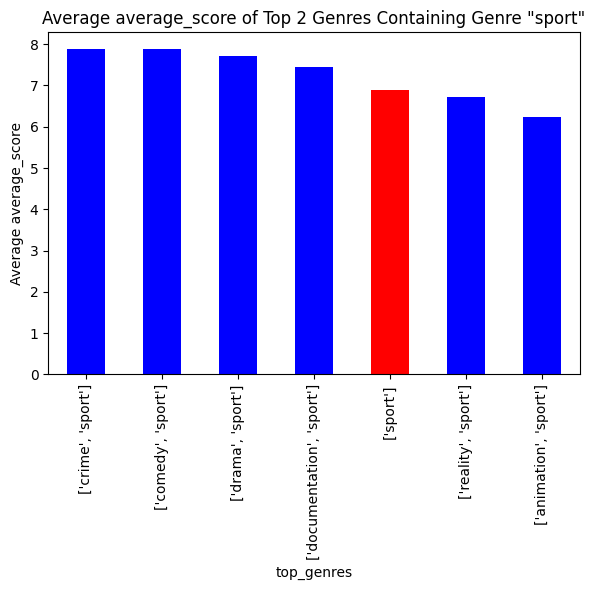

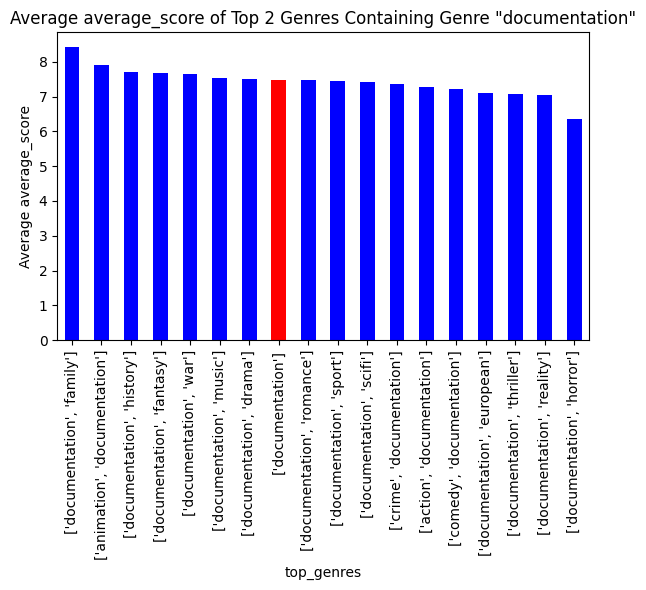

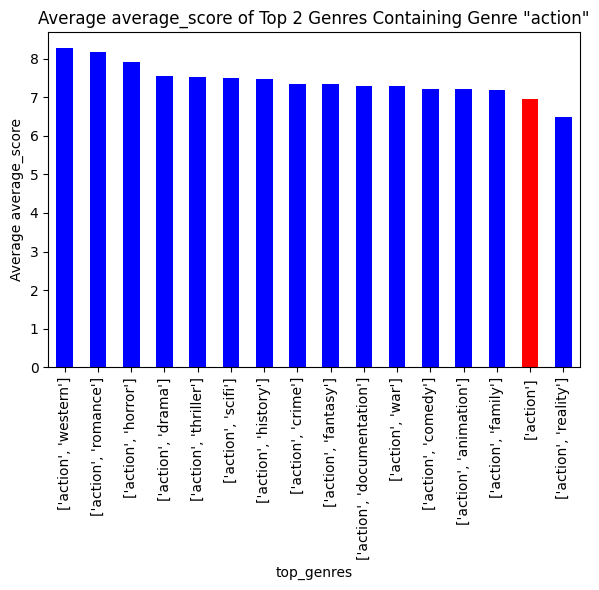

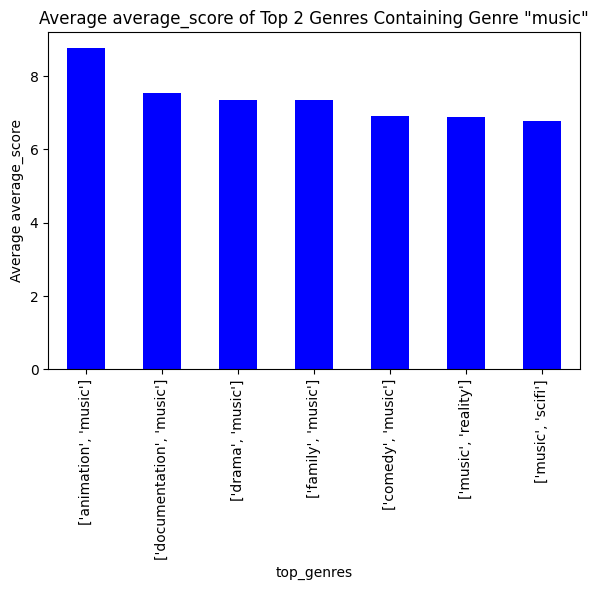

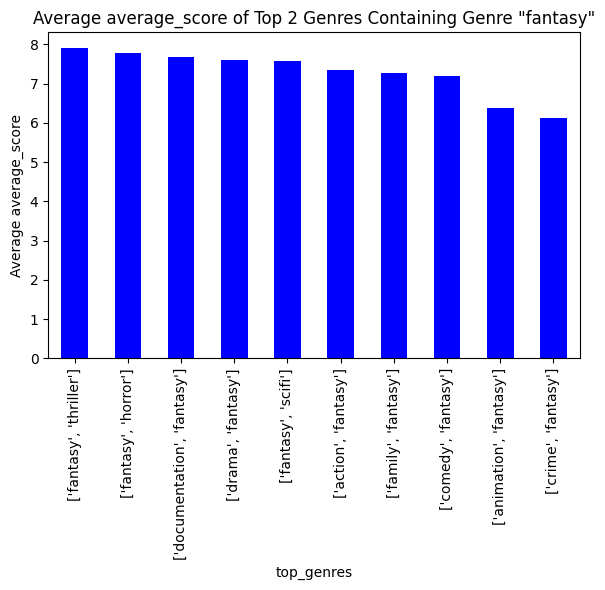

In [39]:
numeric_column = "average_score"

# Plot the average value of 'average_score' for each genre
for genre in unique_genres:
  plot_average_column(colby_df, target_column, genre, numeric_column)

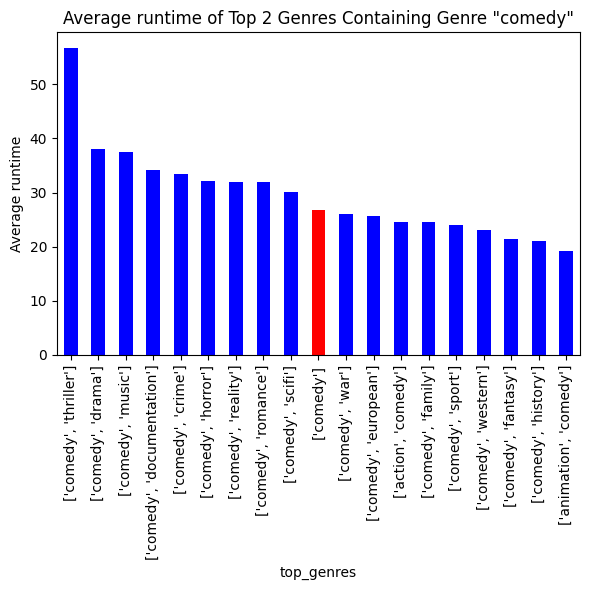

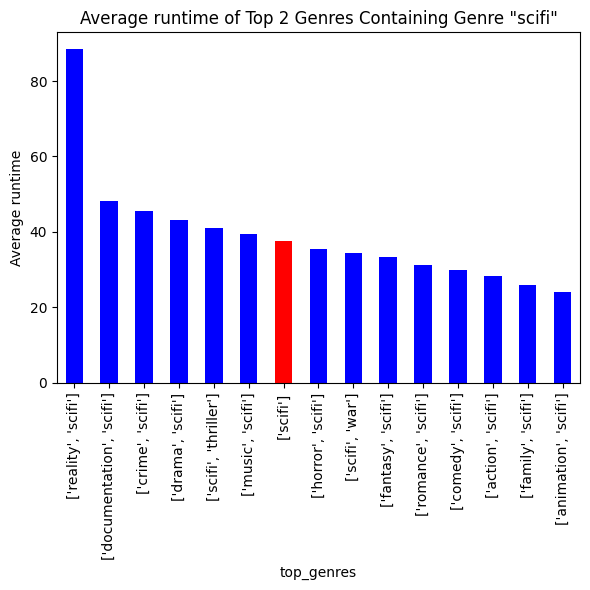

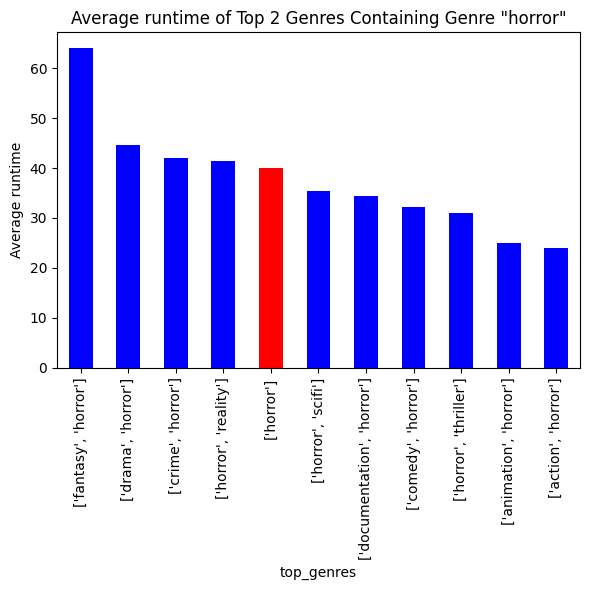

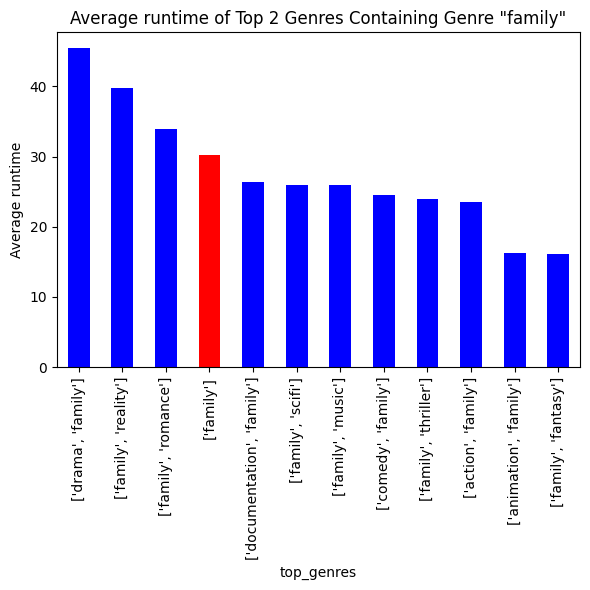

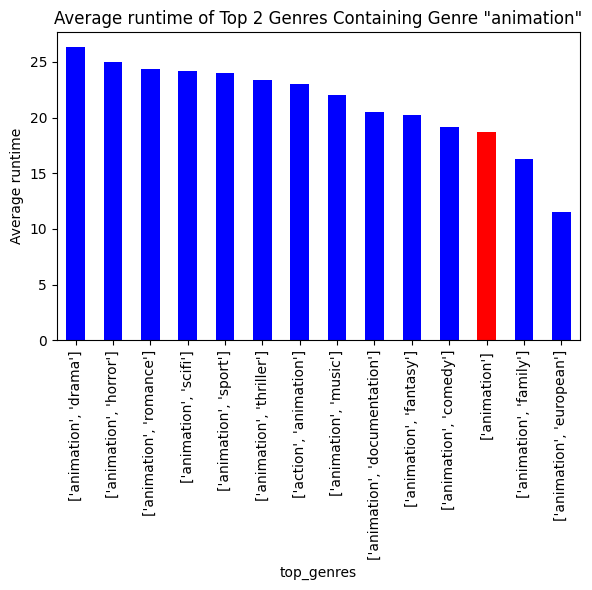

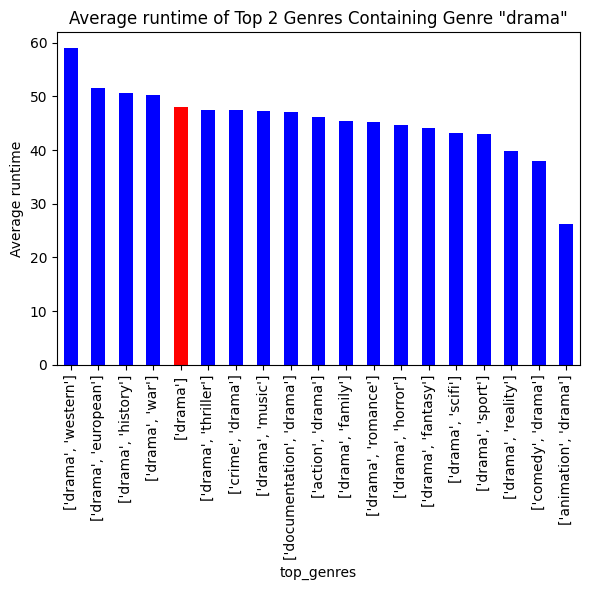

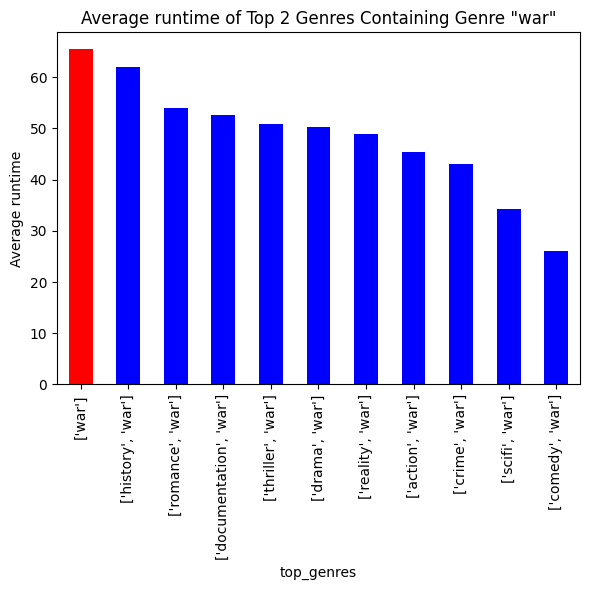

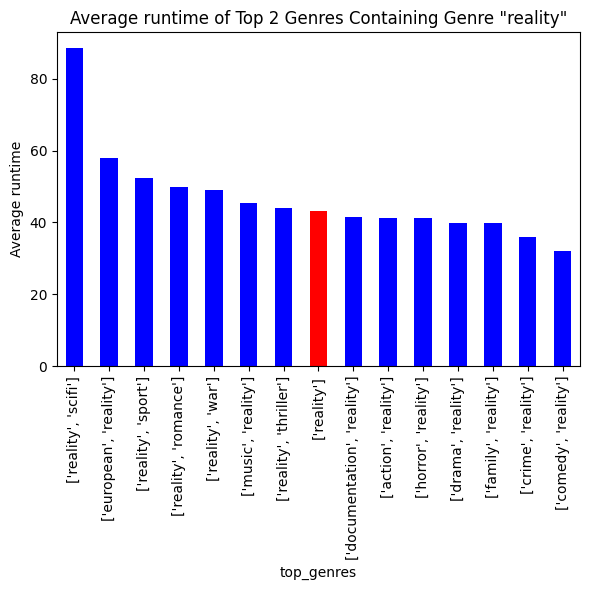

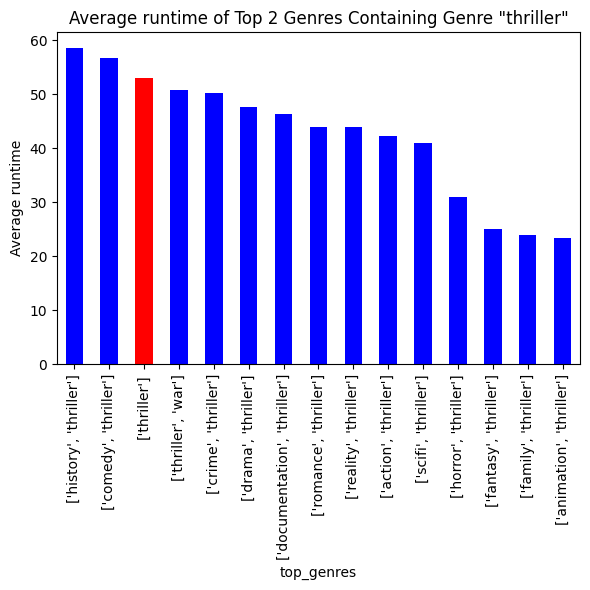

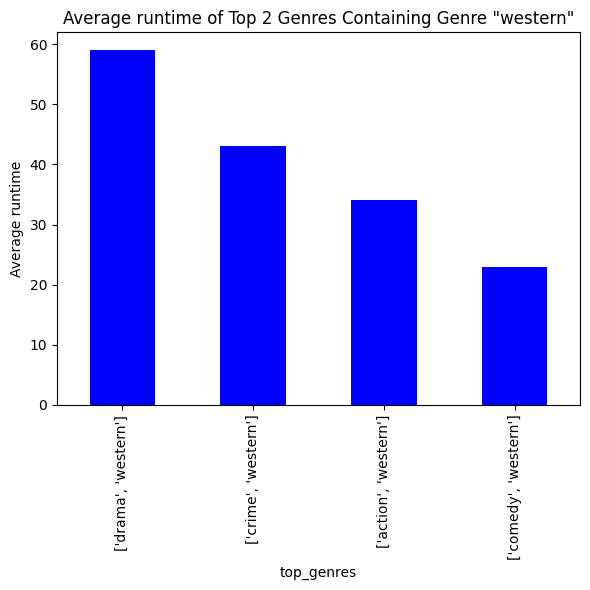

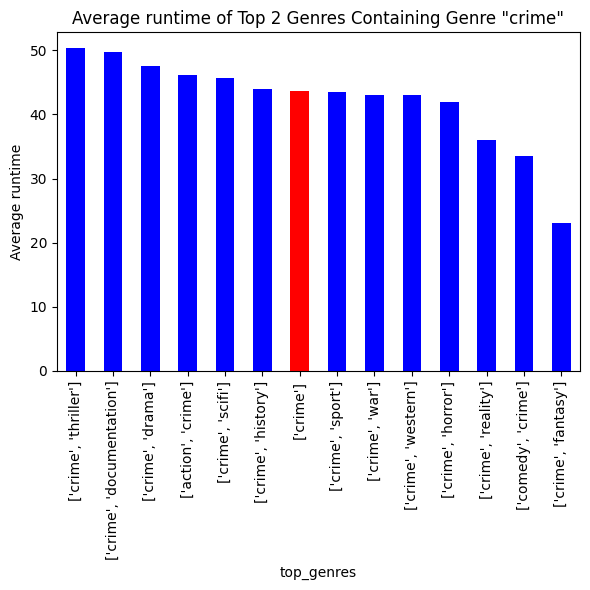

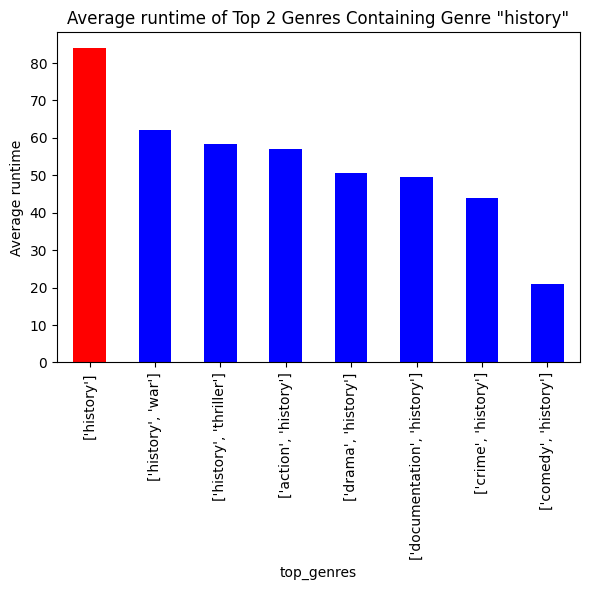

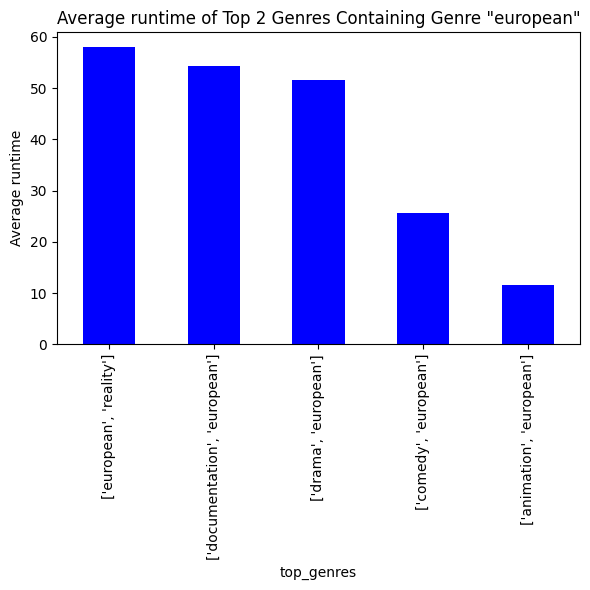

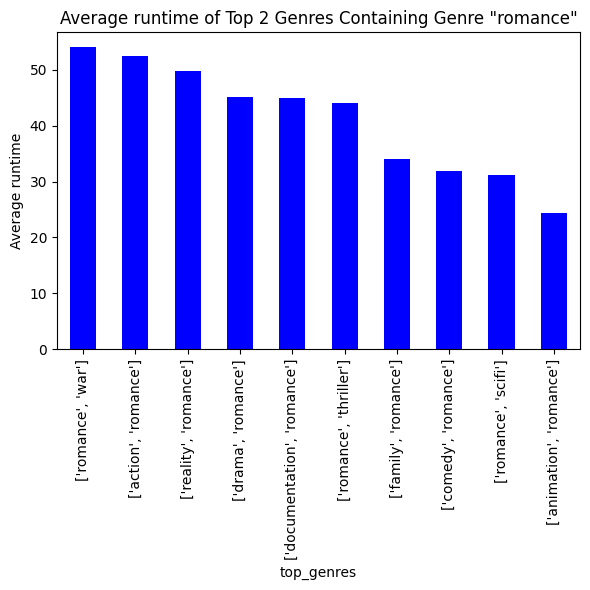

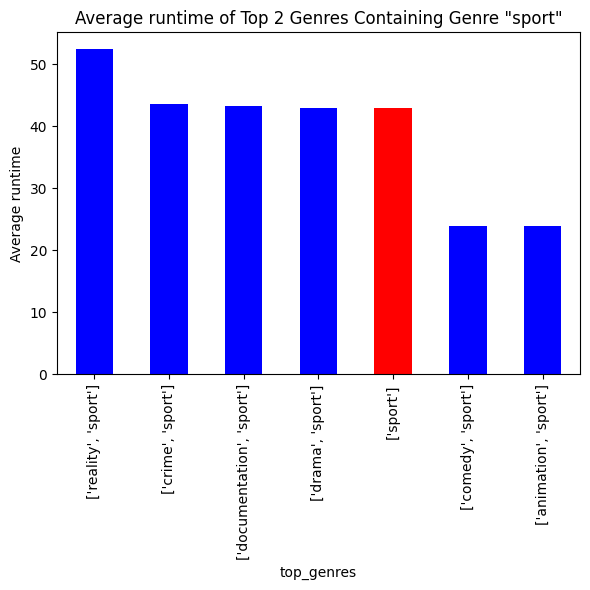

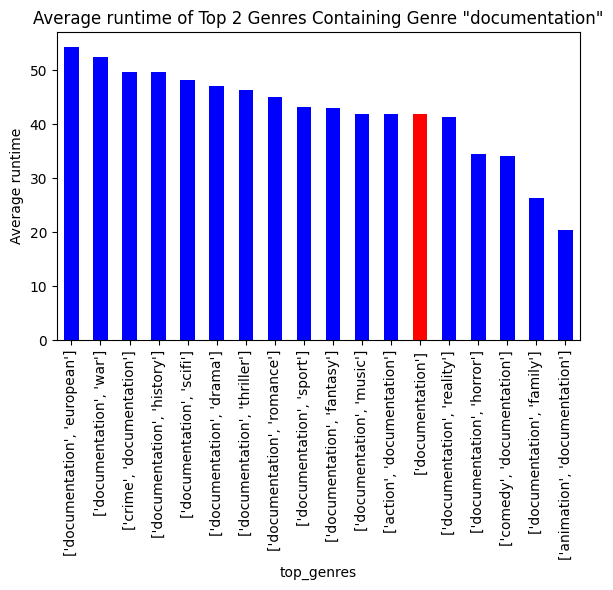

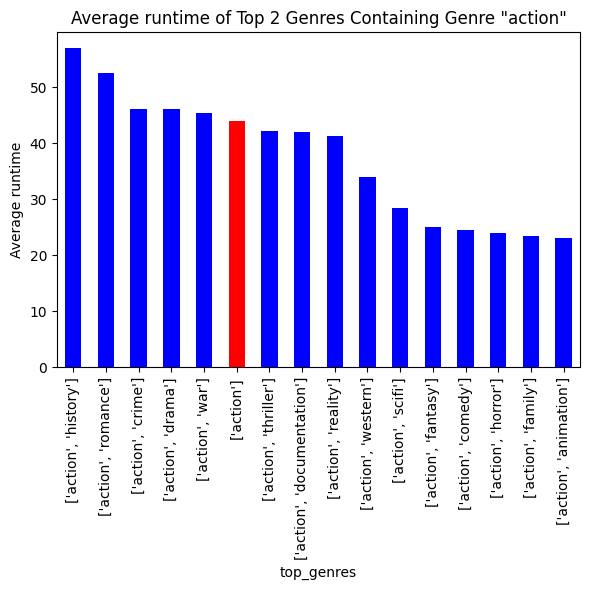

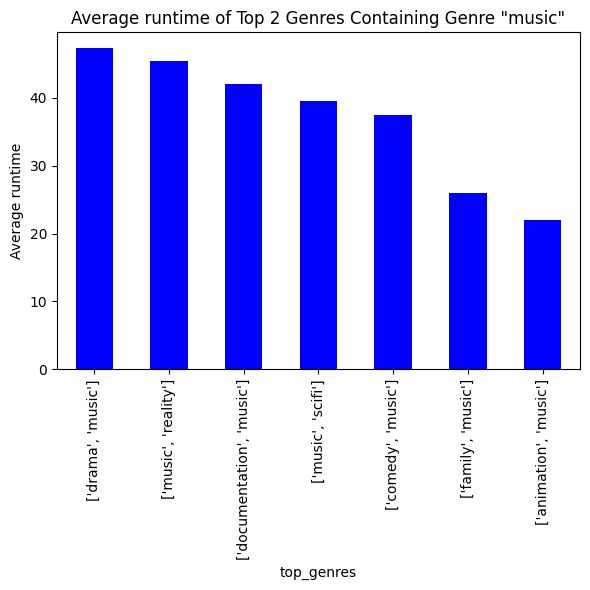

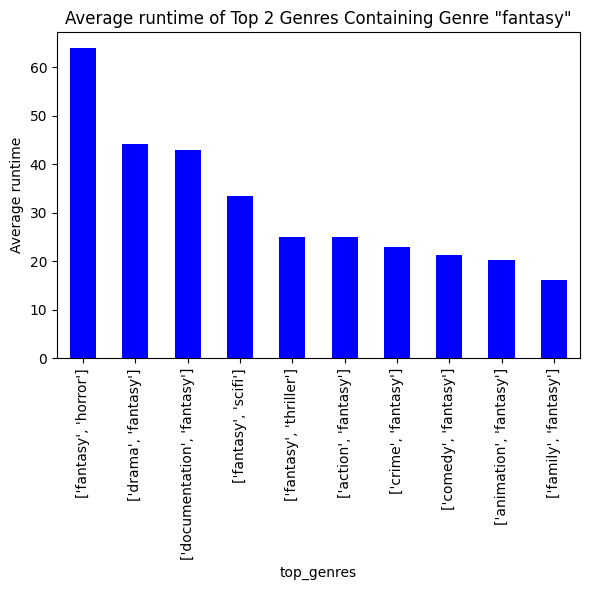

In [35]:
numeric_column = "runtime"

# Plot the average value of 'runtime' for each genre
for genre in unique_genres:
  plot_average_column(colby_df, target_column, genre, numeric_column)

## Plot average age certification for top genres per each unique genre type

In [29]:
print(colby_df["age_certification"].unique())

['TV-14' 'TV-PG' 'TV-G' nan 'TV-Y7' 'TV-MA' 'TV-Y']


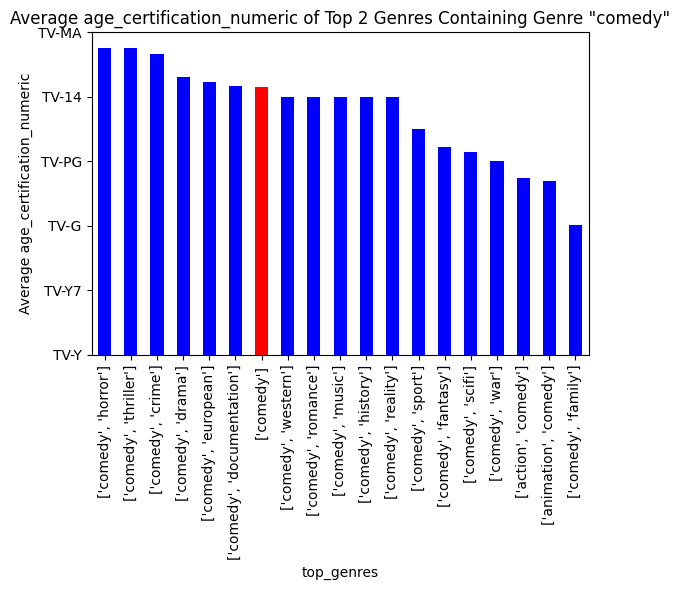

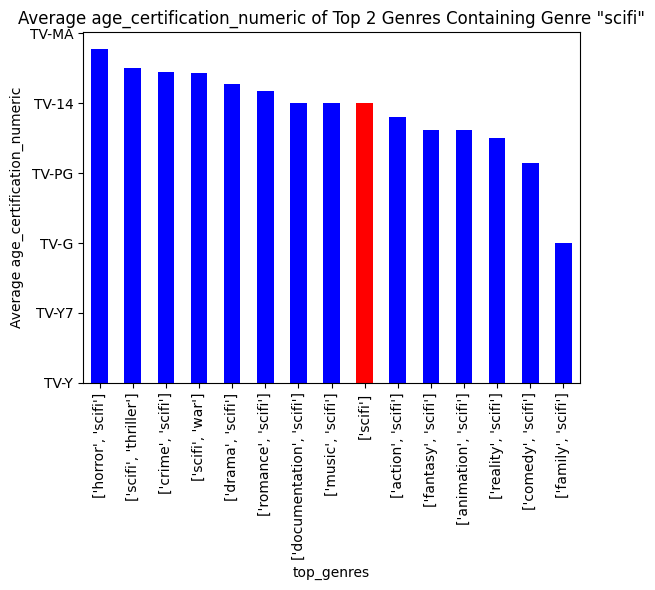

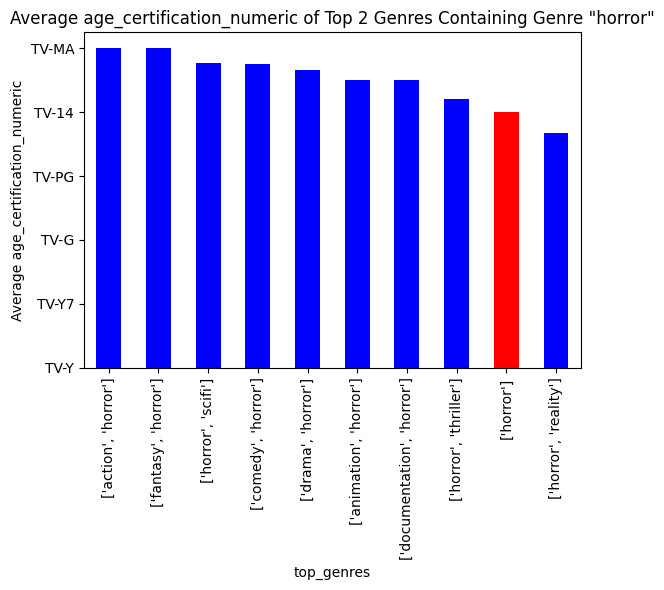

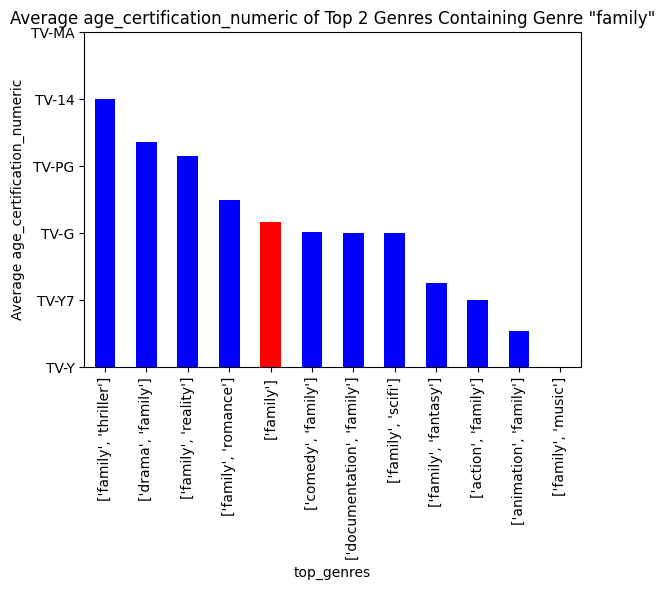

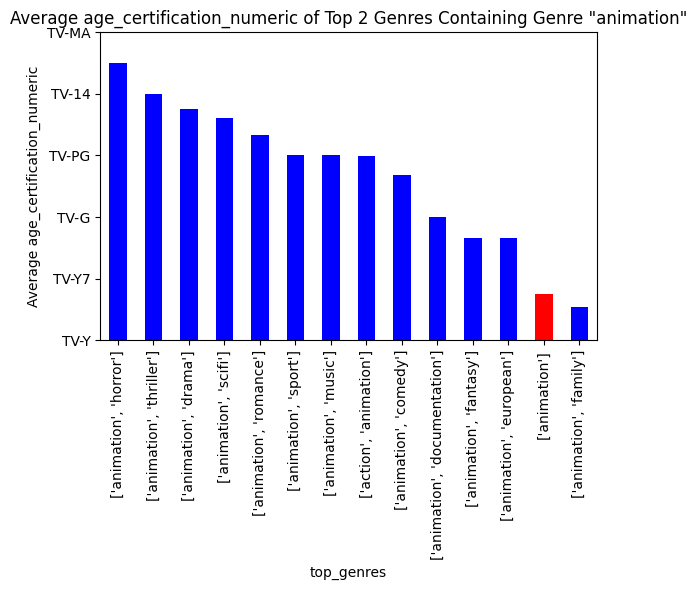

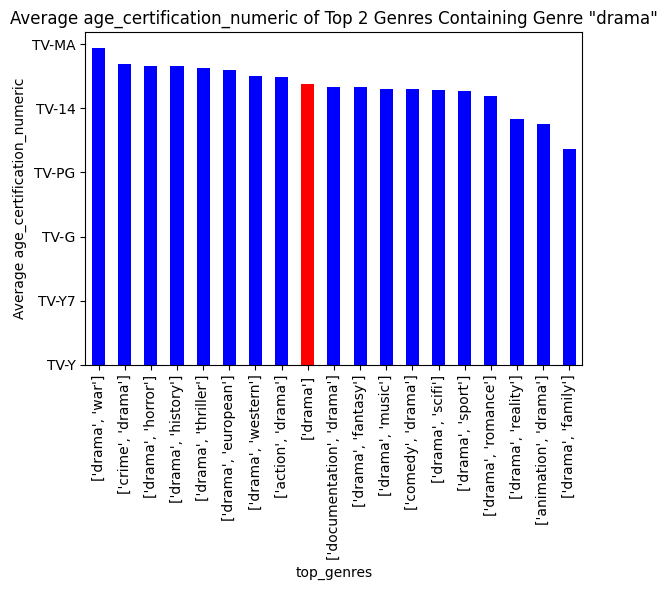

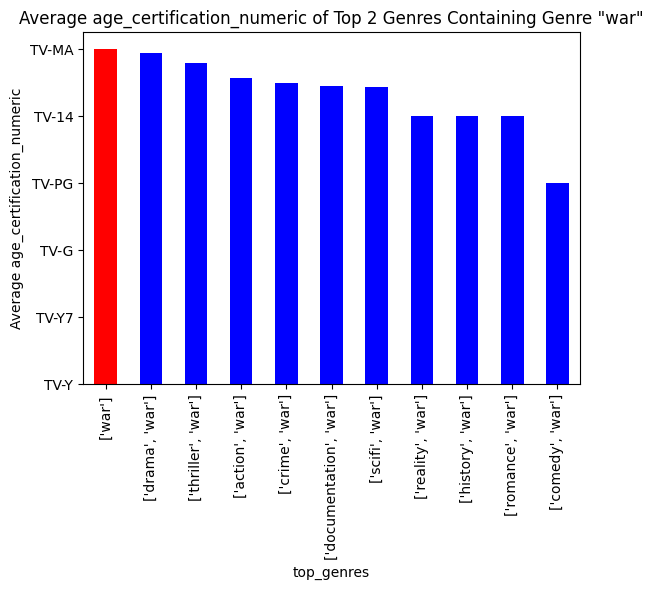

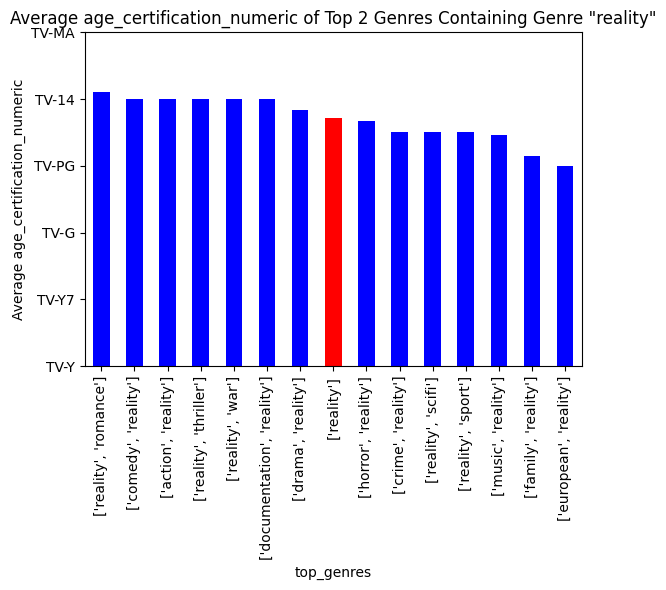

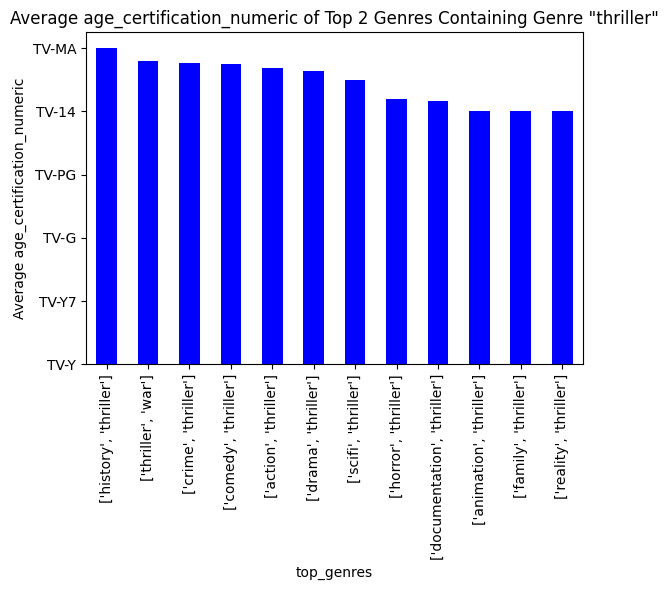

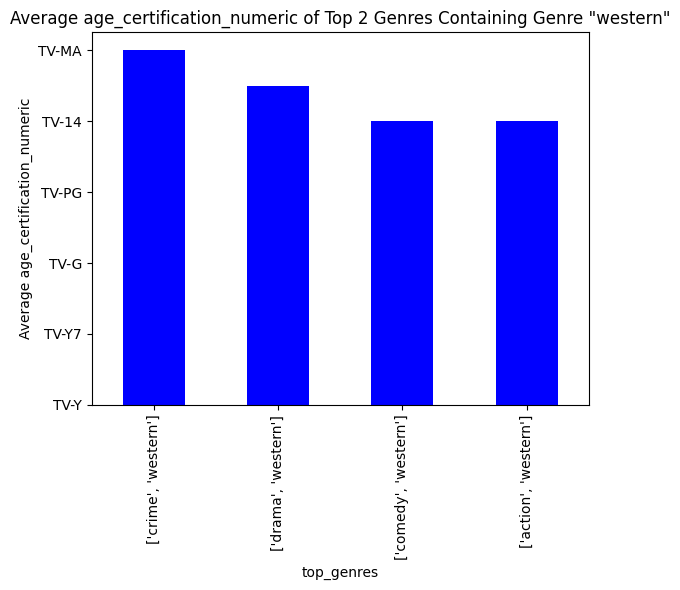

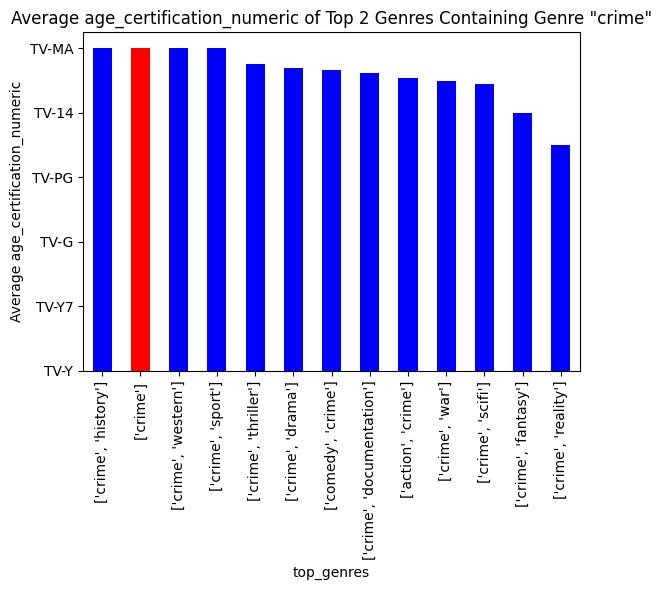

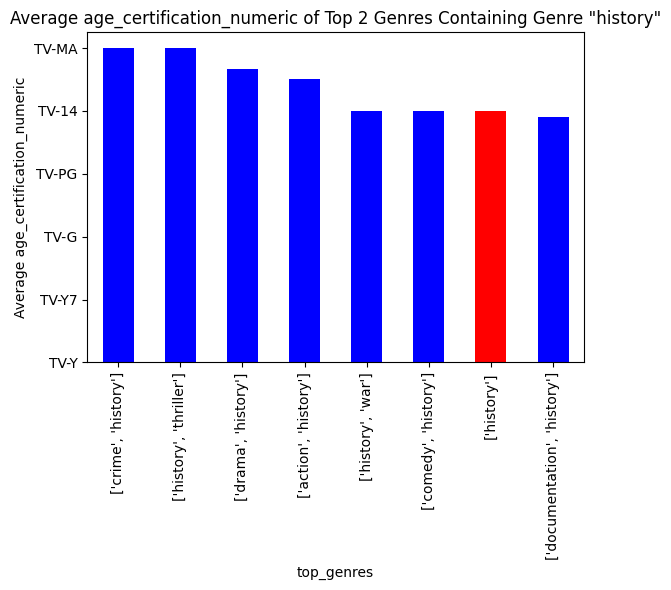

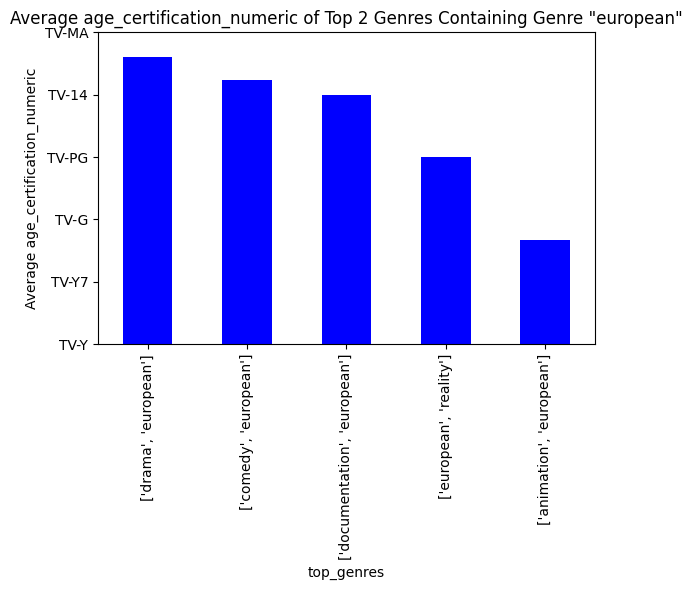

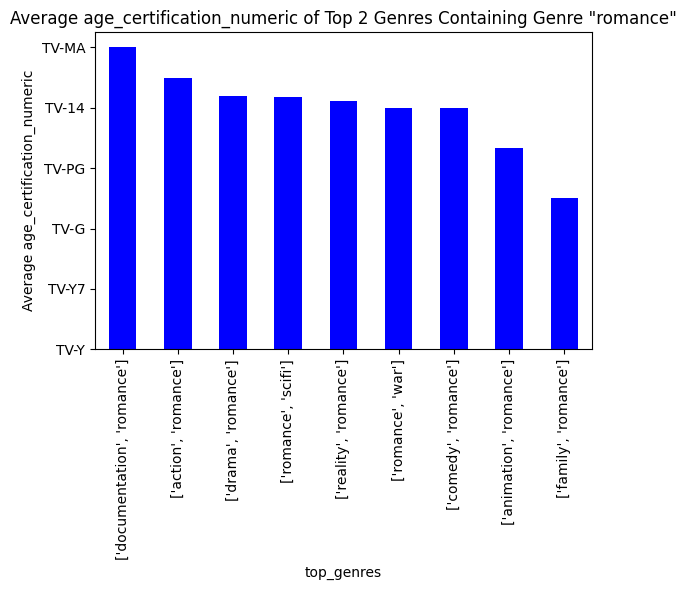

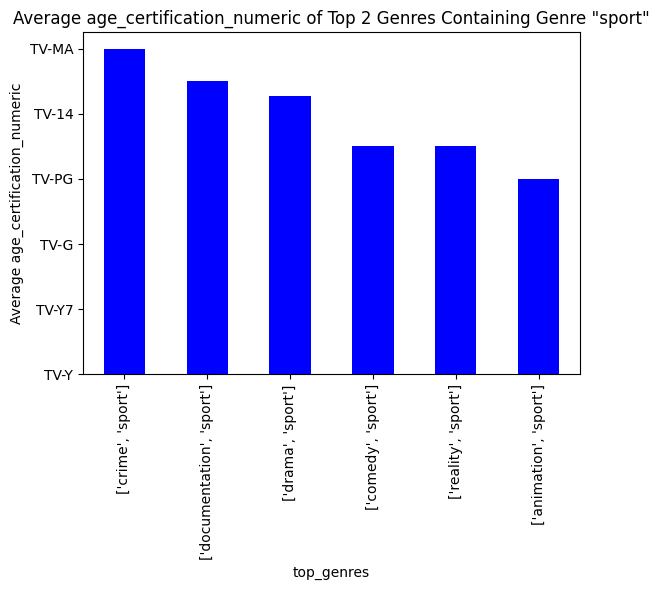

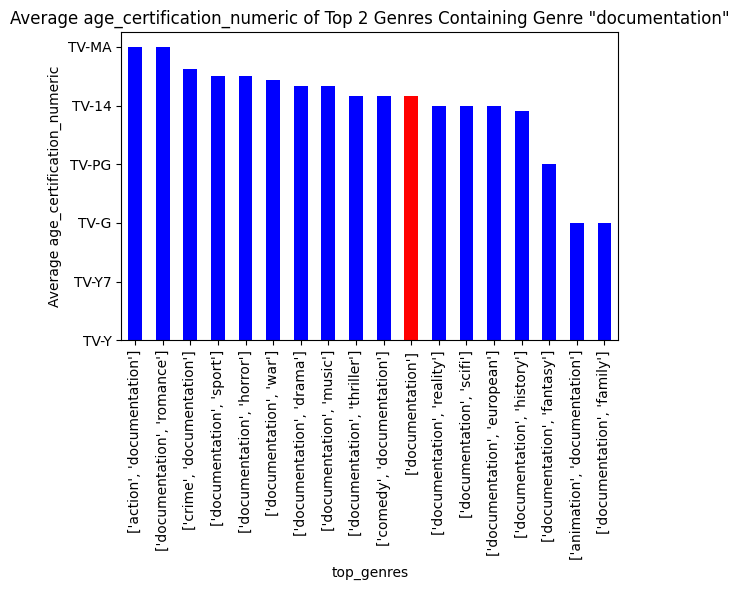

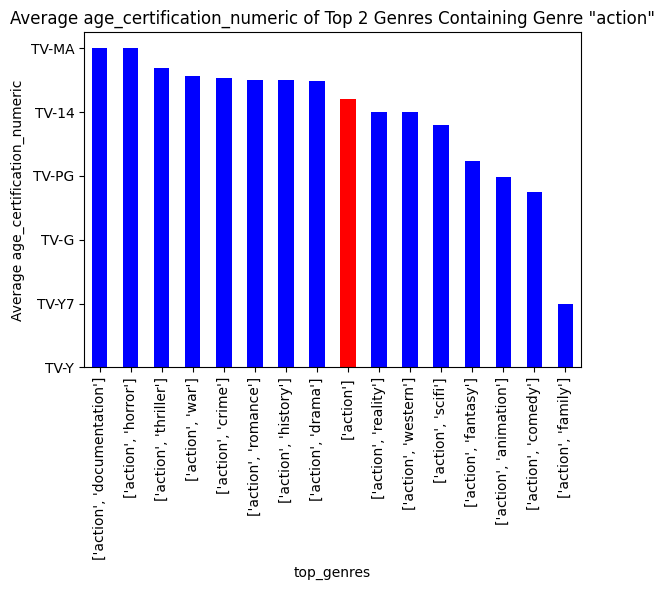

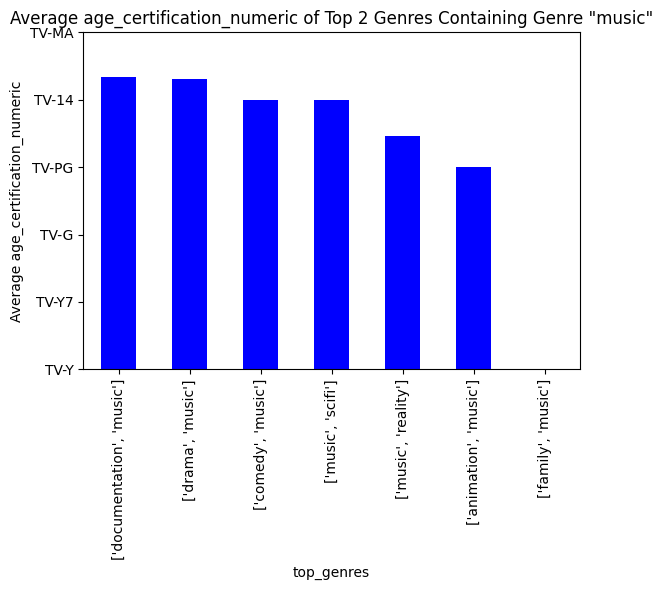

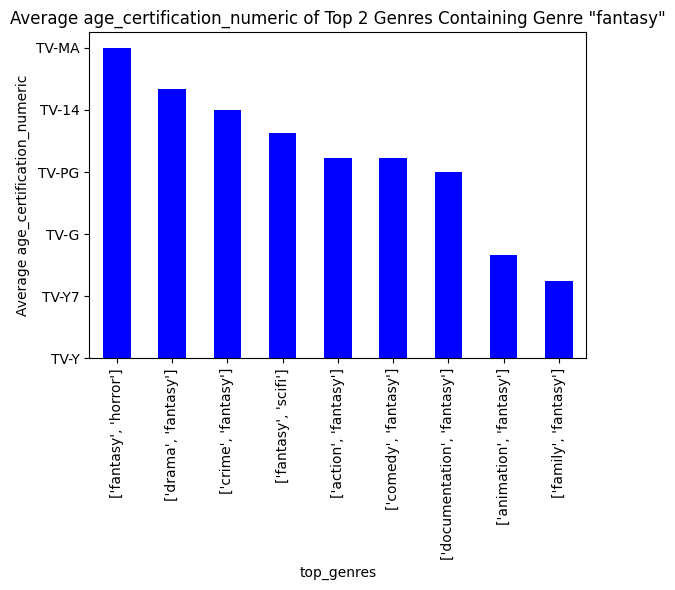

In [30]:
# All of the possible age certifications
age_certifications = {
    "TV-Y": 0,
    "TV-Y7": 1,
    "TV-G": 2,
    "TV-PG": 3,
    "TV-14": 4,
    "TV-MA": 5
}

filtered_df = colby_df.copy()
# Map the age certifications to their numerical value
filtered_df["age_certification_numeric"] = filtered_df["age_certification"].map(age_certifications)

numeric_column = "age_certification_numeric"

# Plot the average (numerical value of) age certification for each genre
for genre in unique_genres:
  plot_average_column(filtered_df, target_column, genre, numeric_column, [[0, 1, 2, 3, 4, 5], ["TV-Y", "TV-Y7", "TV-G", "TV-PG", "TV-14", "TV-MA"]])

## Plot release year for top genres per each unique genre type

<ipython-input-22-add04a6feb62>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x = target_column, y = numeric_column, data = filtered_df, jitter = 0.15, palette = "Set3")


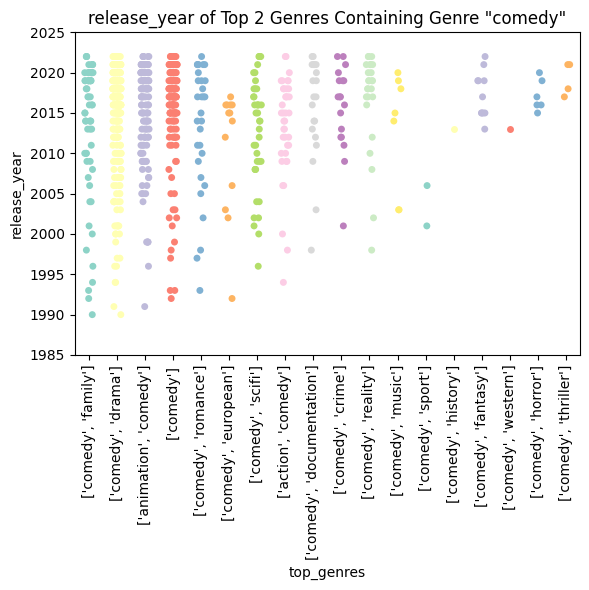

<ipython-input-22-add04a6feb62>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x = target_column, y = numeric_column, data = filtered_df, jitter = 0.15, palette = "Set3")


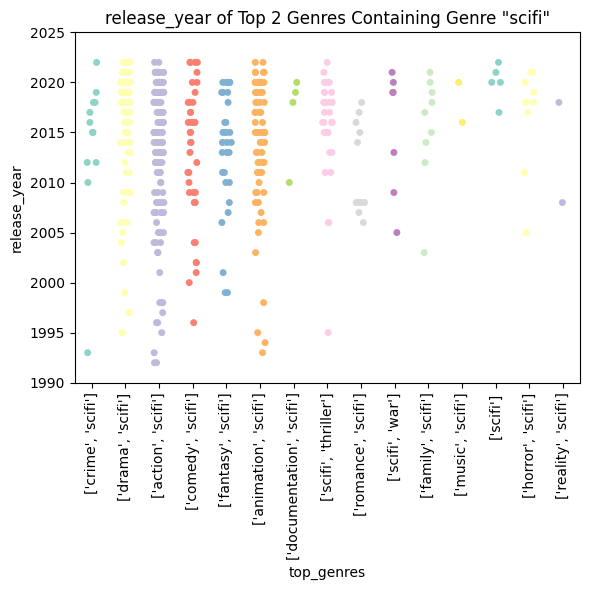

<ipython-input-22-add04a6feb62>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x = target_column, y = numeric_column, data = filtered_df, jitter = 0.15, palette = "Set3")


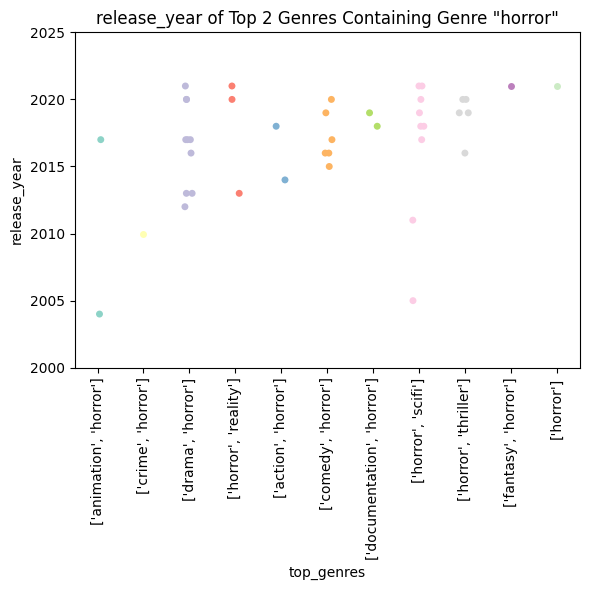

<ipython-input-22-add04a6feb62>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x = target_column, y = numeric_column, data = filtered_df, jitter = 0.15, palette = "Set3")


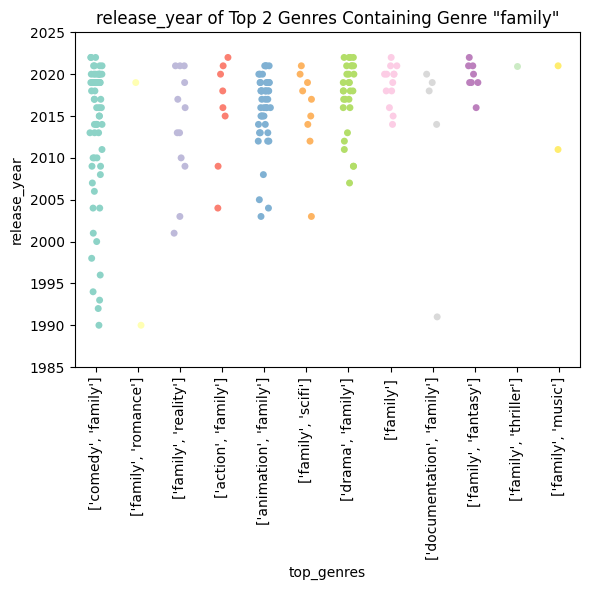

<ipython-input-22-add04a6feb62>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x = target_column, y = numeric_column, data = filtered_df, jitter = 0.15, palette = "Set3")


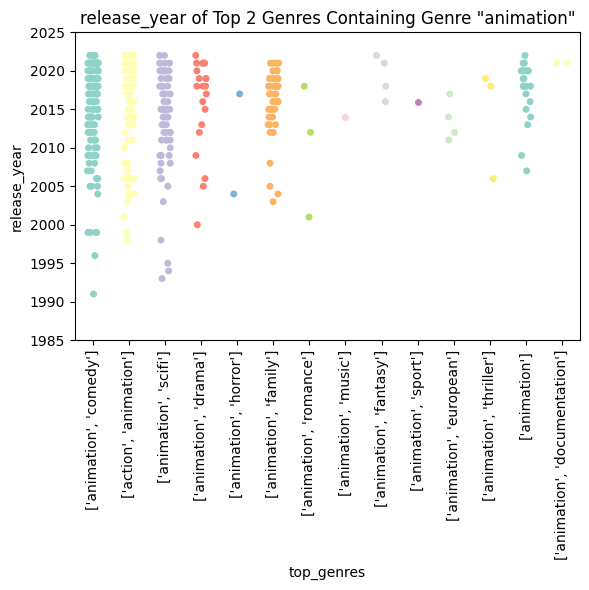

<ipython-input-22-add04a6feb62>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x = target_column, y = numeric_column, data = filtered_df, jitter = 0.15, palette = "Set3")


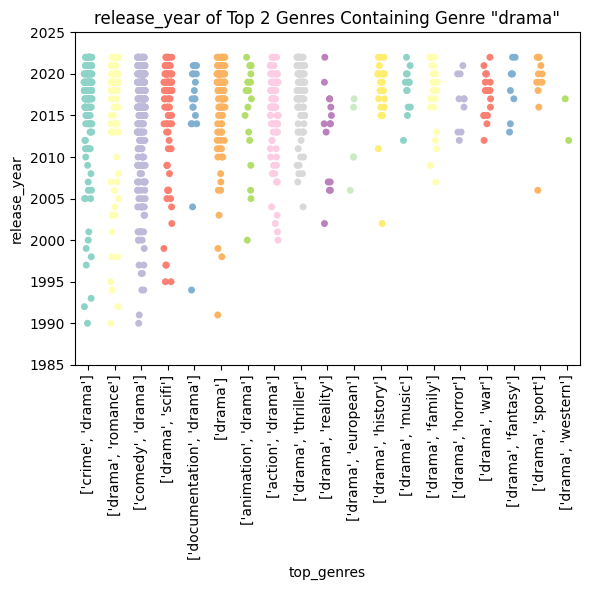

<ipython-input-22-add04a6feb62>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x = target_column, y = numeric_column, data = filtered_df, jitter = 0.15, palette = "Set3")


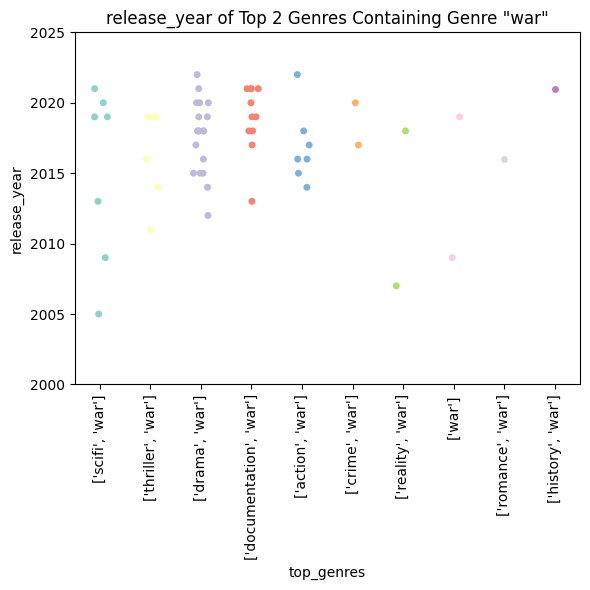

<ipython-input-22-add04a6feb62>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x = target_column, y = numeric_column, data = filtered_df, jitter = 0.15, palette = "Set3")


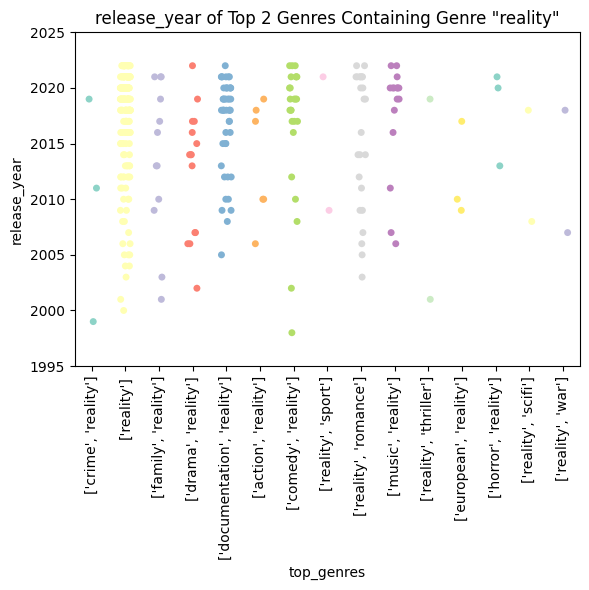

<ipython-input-22-add04a6feb62>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x = target_column, y = numeric_column, data = filtered_df, jitter = 0.15, palette = "Set3")


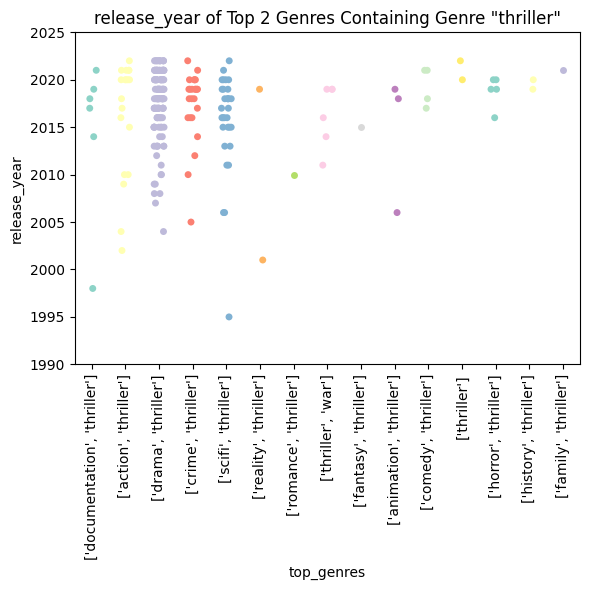

<ipython-input-22-add04a6feb62>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x = target_column, y = numeric_column, data = filtered_df, jitter = 0.15, palette = "Set3")


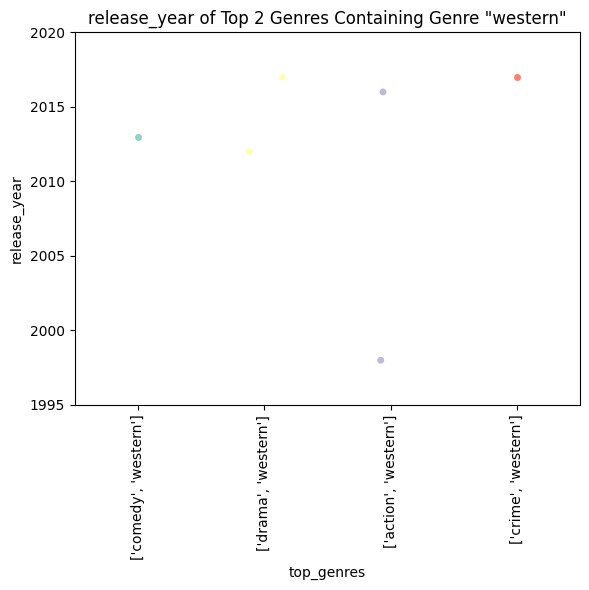

<ipython-input-22-add04a6feb62>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x = target_column, y = numeric_column, data = filtered_df, jitter = 0.15, palette = "Set3")


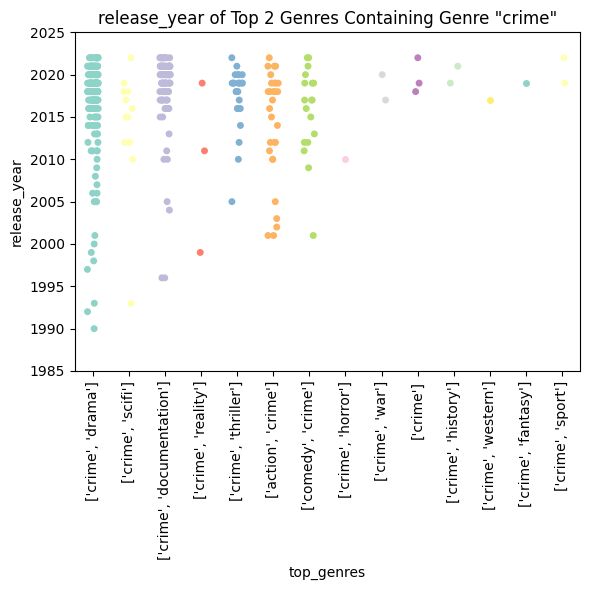

<ipython-input-22-add04a6feb62>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x = target_column, y = numeric_column, data = filtered_df, jitter = 0.15, palette = "Set3")


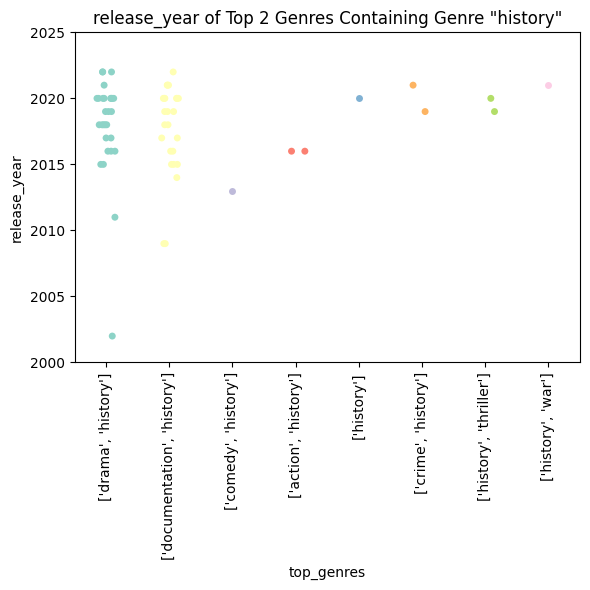

<ipython-input-22-add04a6feb62>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x = target_column, y = numeric_column, data = filtered_df, jitter = 0.15, palette = "Set3")


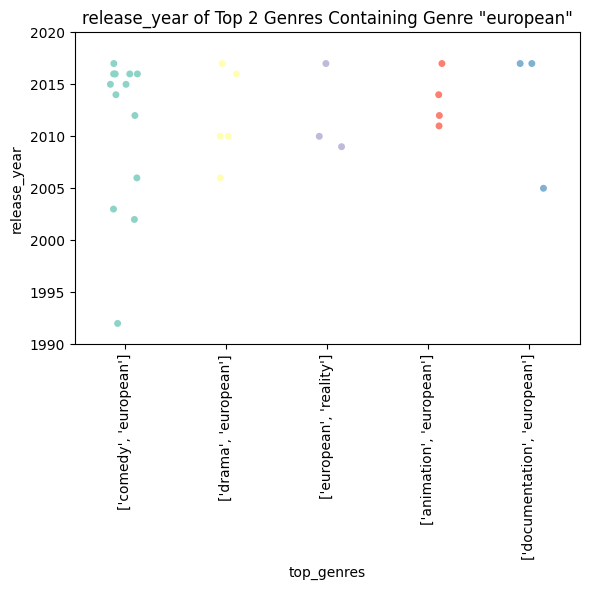

<ipython-input-22-add04a6feb62>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x = target_column, y = numeric_column, data = filtered_df, jitter = 0.15, palette = "Set3")


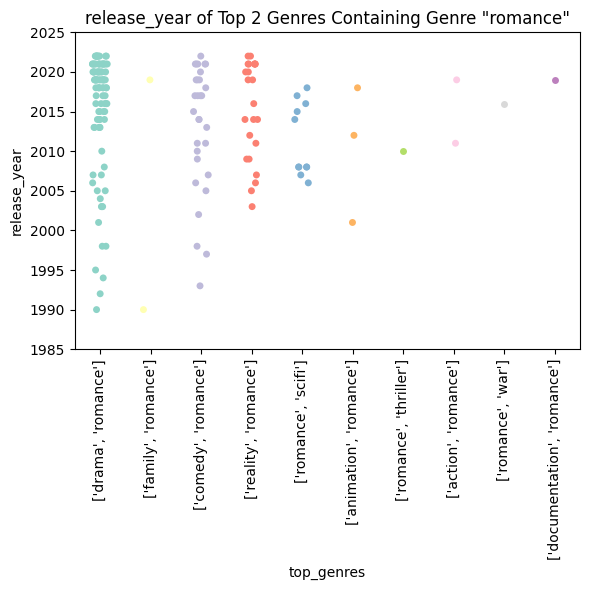

<ipython-input-22-add04a6feb62>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x = target_column, y = numeric_column, data = filtered_df, jitter = 0.15, palette = "Set3")


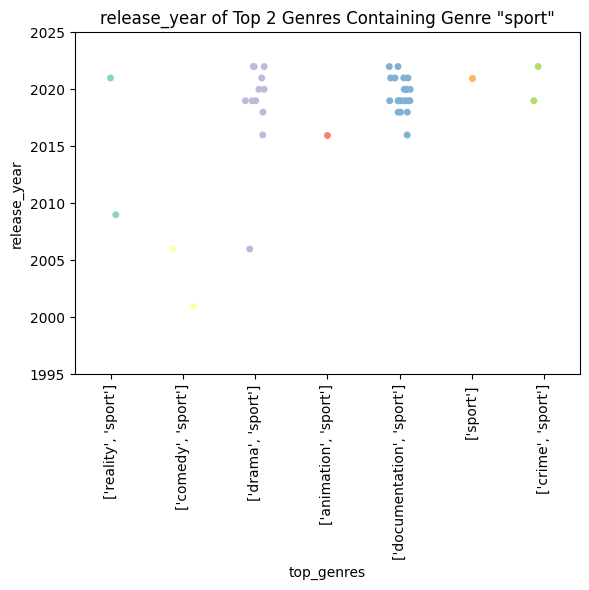

<ipython-input-22-add04a6feb62>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x = target_column, y = numeric_column, data = filtered_df, jitter = 0.15, palette = "Set3")


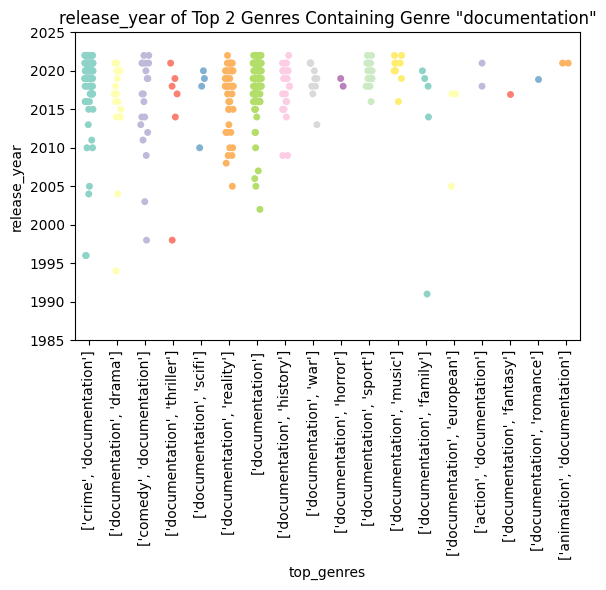

<ipython-input-22-add04a6feb62>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x = target_column, y = numeric_column, data = filtered_df, jitter = 0.15, palette = "Set3")


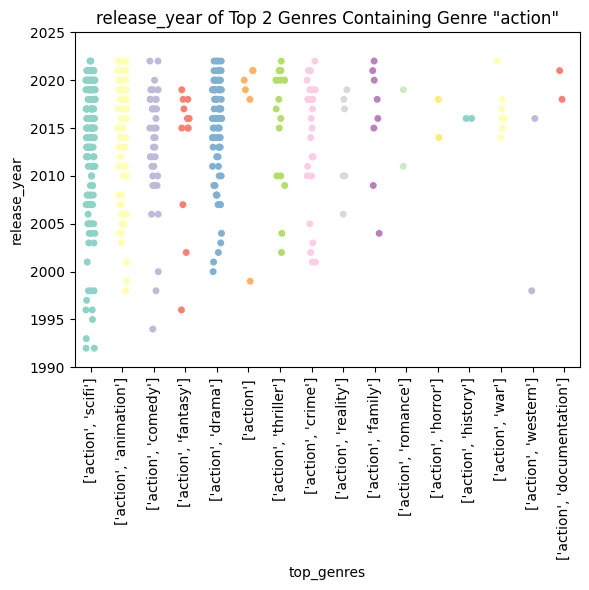

<ipython-input-22-add04a6feb62>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x = target_column, y = numeric_column, data = filtered_df, jitter = 0.15, palette = "Set3")


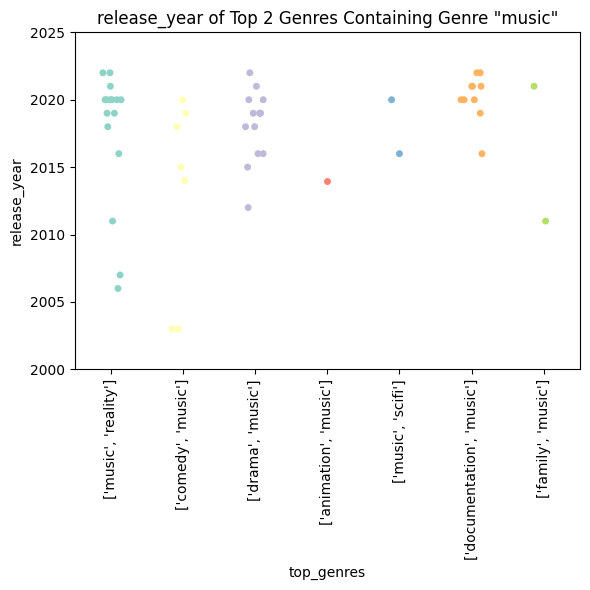

<ipython-input-22-add04a6feb62>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x = target_column, y = numeric_column, data = filtered_df, jitter = 0.15, palette = "Set3")


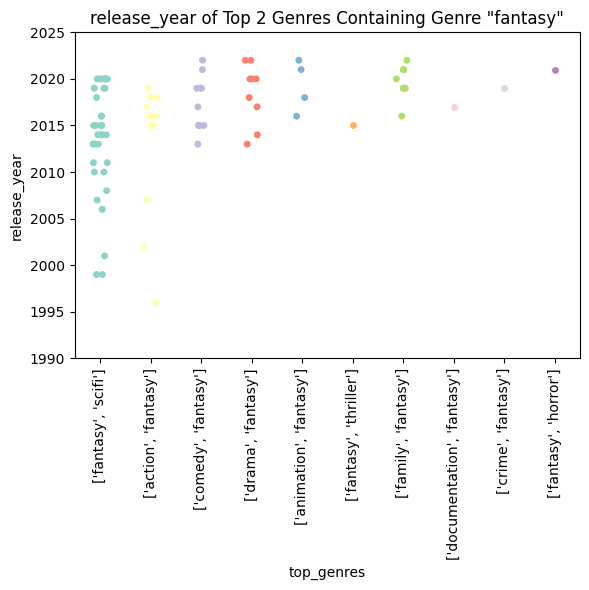

In [38]:
numeric_column = "release_year"

# Plot the release year for each genre. I filtered out values less than 1990 and greater than 2025 because the number of values outside of this range are few
for genre in unique_genres:
  plot_strip_column(colby_df[(colby_df[numeric_column] >= 1990) & (colby_df[numeric_column] <= 2025)], target_column, genre, numeric_column)

## Export query dataset

In [ ]:
final_df = colby_df.copy()
final_df.to_csv("colby_eda.csv", index=False)